In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Dinesh
[nltk_data]     Chauhan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Dinesh
[nltk_data]     Chauhan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
def load_data(file_path):
    """
    Load the dataset and display an overview.

    Parameters:
    - file_path: Path to the dataset file.

    Returns:
    - data: Loaded DataFrame.
    """
    data = pd.read_excel(file_path)
    print("Dataset shape:", data.shape)
    print("Data types:\n", data.dtypes)
    print("Missing values:\n", data.isnull().sum().values)
    return data

# Usage
file_path = "Data+Set+-+industrial_safety_and_health_database_with_accidents_description.xlsx"
data = load_data('capstonedata.xlsx')


Dataset shape: (425, 11)
Data types:
 Unnamed: 0                           int64
Data                        datetime64[ns]
Countries                           object
Local                               object
Industry Sector                     object
Accident Level                      object
Potential Accident Level            object
Genre                               object
Employee or Third Party             object
Critical Risk                       object
Description                         object
dtype: object
Missing values:
 [0 0 0 0 0 0 0 0 0 0 0]


In [20]:
import pandas as pd

def preprocess_data(df):
    """
    Rename columns and drop irrelevant columns.

    Parameters:
    - df: DataFrame to preprocess.

    Returns:
    - df: Preprocessed DataFrame with renamed columns and irrelevant columns dropped.
    """
    # Rename columns
    df.rename(columns={
        'Data': 'Date',
        'Industry Sector': 'Industry_Sector',
        'Accident Level': 'Accident_Level',
        'Countries': 'Country',
        'Genre': 'Gender',
        'Potential Accident Level': 'Potential_Accident_Level',
        'Employee or Third Party': 'Employee_Type',
        'Critical Risk': 'Critical_Risk'
    }, inplace=True)

    # Drop columns with 'Unnamed'
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    return df


data = preprocess_data(data)


In [21]:
def analyze_dataframe(df):
    """
    Perform an analysis on the DataFrame and display an overview.

    Parameters:
    - df: DataFrame to analyze.

    Returns:
    - None
    """
    if df.empty:
        print("DataFrame is empty. Please check your data.")
        return

    print("Dataset Shape:", df.shape)
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())

    # Descriptive statistics for numerical columns
    if df.select_dtypes(include=[np.number]).shape[1] > 0:
        print("\nDescriptive Statistics (Numerical Columns):\n", df.describe(include=[np.number]))
    else:
        print("\nNo numerical columns to describe.")

    # Descriptive statistics for categorical columns
    if df.select_dtypes(include=[object, 'category']).shape[1] > 0:
        print("\nDescriptive Statistics (Categorical Columns):\n", df.describe(include=[object, 'category']))
    else:
        print("\nNo categorical columns to describe.")

    # First few rows of the DataFrame
    print("\nFirst Few Rows:\n", df.head())


In [22]:
analyze_dataframe(data)

Dataset Shape: (425, 10)

Data Types:
 Date                        datetime64[ns]
Country                             object
Local                               object
Industry_Sector                     object
Accident_Level                      object
Potential_Accident_Level            object
Gender                              object
Employee_Type                       object
Critical_Risk                       object
Description                         object
dtype: object

Missing Values:
 Date                        0
Country                     0
Local                       0
Industry_Sector             0
Accident_Level              0
Potential_Accident_Level    0
Gender                      0
Employee_Type               0
Critical_Risk               0
Description                 0
dtype: int64

No numerical columns to describe.

Descriptive Statistics (Categorical Columns):
            Country     Local Industry_Sector Accident_Level  \
count          425       425            

**Country, Local, Industry_Sector:** The data is spread across 3 countries, 12 locations, and 3 industry sectors, with “Country_01,” “Local_03,” and “Mining” being the most frequent values.

**Accident_Level: **There are 5 unique accident levels, with level “I” being the most common (316 occurrences).

**Potential_Accident_Level:** There are 6 unique potential accident levels, with level “IV” being the most frequent.

**Gender:** The majority of records are for males (403 occurrences).

**Employee_Type:** “Third Party” is the most common employee type.

**Critical_Risk:** There are 33 unique critical risks, with “Others” being the most common.

**Description:** There are 411 unique descriptions, indicating that most accident descriptions are unique, though there are a few duplicates.

In [23]:
def handle_duplicates(df):
    """
    Find and drop duplicate values in the DataFrame.

    Parameters:
    - df: DataFrame to check for duplicates.

    Returns:
    - df: DataFrame after removing duplicates.
    """
    # Check for duplicates
    duplicates = df.duplicated()
    num_duplicates = duplicates.sum()

    if num_duplicates > 0:
        print(f"Found {num_duplicates} duplicate rows. Dropping them...")
        # Drop duplicates
        df = df.drop_duplicates()
        print(f"New dataset shape after dropping duplicates: {df.shape}")
    else:
        print("No duplicate rows found.")

    return df


data = handle_duplicates(data)


Found 7 duplicate rows. Dropping them...
New dataset shape after dropping duplicates: (418, 10)


In [24]:
analyze_dataframe(data)

Dataset Shape: (418, 10)

Data Types:
 Date                        datetime64[ns]
Country                             object
Local                               object
Industry_Sector                     object
Accident_Level                      object
Potential_Accident_Level            object
Gender                              object
Employee_Type                       object
Critical_Risk                       object
Description                         object
dtype: object

Missing Values:
 Date                        0
Country                     0
Local                       0
Industry_Sector             0
Accident_Level              0
Potential_Accident_Level    0
Gender                      0
Employee_Type               0
Critical_Risk               0
Description                 0
dtype: int64

No numerical columns to describe.

Descriptive Statistics (Categorical Columns):
            Country     Local Industry_Sector Accident_Level  \
count          418       418            

One can observe in the above dataframe that there are only 411 unique values in the Description column but we have 418 number of records in total, we can assume that there are still 7 number of duplicate values on description column.
We will check for those duplicates on column level and drop if required for further analysis.

In [25]:
def inspect_description_duplicates(df):
    """
    Inspect rows with duplicate values in the 'Description' column.

    Parameters:
    - df: DataFrame to inspect for duplicate descriptions.

    Returns:
    - None
    """
    if 'Description' not in df.columns:
        print("The 'Description' column is not present in the DataFrame.")
        return

    # Find duplicate descriptions
    duplicates = df[df.duplicated(subset='Description', keep=False)]

    if duplicates.shape[0] > 0:
        print("Sample of rows with duplicate descriptions:")
        print(duplicates[['Description']].drop_duplicates().head())
    else:
        print("No duplicate descriptions to inspect.")


inspect_description_duplicates(data)


Sample of rows with duplicate descriptions:
                                           Description
37   When starting the activity of removing a coil ...
130  In the geological reconnaissance activity, in ...
143  Project of Vazante that carried out sediment c...
166  At moments when the MAPERU truck of plate F1T ...
261  During the activity of chuteo of ore in hopper...


In [26]:
def remove_description_duplicates(df):
    """
    Remove duplicate rows based on the 'Description' column.

    Parameters:
    - df: DataFrame to remove duplicate descriptions.

    Returns:
    - df: DataFrame after removing duplicate descriptions.
    """
    if 'Description' not in df.columns:
        print("The 'Description' column is not present in the DataFrame.")
        return df

    # Drop duplicates in the 'Description' column while keeping the first occurrence
    df_cleaned = df.drop_duplicates(subset='Description', keep='first')

    # Output the number of duplicates removed
    num_removed = df.shape[0] - df_cleaned.shape[0]
    print(f"Removed {num_removed} duplicate rows based on 'Description' column.")

    return df_cleaned


data = remove_description_duplicates(data)


Removed 7 duplicate rows based on 'Description' column.


In [27]:
analyze_dataframe(data)

Dataset Shape: (411, 10)

Data Types:
 Date                        datetime64[ns]
Country                             object
Local                               object
Industry_Sector                     object
Accident_Level                      object
Potential_Accident_Level            object
Gender                              object
Employee_Type                       object
Critical_Risk                       object
Description                         object
dtype: object

Missing Values:
 Date                        0
Country                     0
Local                       0
Industry_Sector             0
Accident_Level              0
Potential_Accident_Level    0
Gender                      0
Employee_Type               0
Critical_Risk               0
Description                 0
dtype: int64

No numerical columns to describe.

Descriptive Statistics (Categorical Columns):
            Country     Local Industry_Sector Accident_Level  \
count          411       411            

Now we can see that after removing the duplicates the count of unique values in the description column and the total number of datapoints in the dataset is matching.

**EDA (Data Analysis and Preparation)**

**Univariate Analysis**

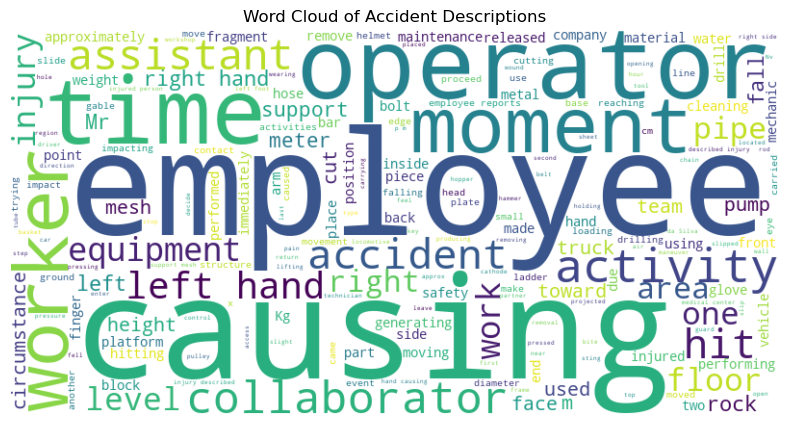

In [28]:
from wordcloud import WordCloud

def plot_word_cloud(data):
    """
    Plot a Word Cloud for Accident Descriptions.

    Parameters:
    - data: DataFrame containing the dataset.
    """
    text = " ".join(desc for desc in data['Description'])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('Word Cloud of Accident Descriptions')
    plt.show()

plot_word_cloud(data)

In [29]:
def plot_univariate(df, col, title, palette):
    """
    Create univariate plots including a violin plot and a pie chart.

    Parameters:
    - df: DataFrame containing the dataset.
    - col: Column to be analyzed.
    - title: Title for the plots.
    - palette: Color palette for the plots.
    """
    plt.figure(figsize=(20, 15))

     # Violin plot
    plt.subplot(2, 2, 1)
    #sns.violinplot(x=df[col], palette=palette)
    plt.title(f"{title} - Violin Plot")

    # Pie chart
    plt.subplot(2, 2, 2)
    plt.pie(df[col].value_counts(), autopct="%.2f%%",
            labels=df[col].value_counts().index, shadow=True,
            explode=[0.1]*len(df[col].value_counts().index), startangle=-135)
    plt.title(f"{title} - Pie Chart")

    plt.show()


**Industry Sector**

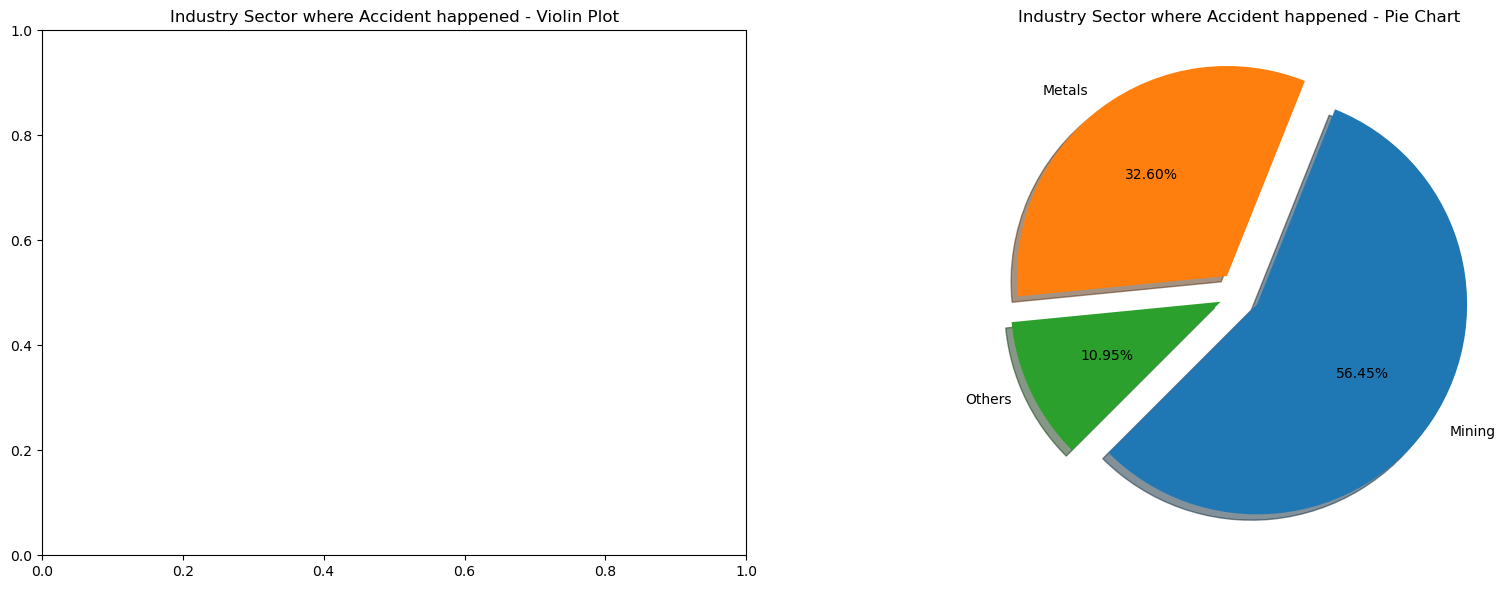

In [30]:
plot_univariate(data, 'Industry_Sector', 'Industry Sector where Accident happened', 'Set2')


It is evident that the mining industry experiences a higher frequency of accidents compared to the metal industry. Therefore, jobs in mining are considerably riskier than those in the metal sector.

**Gender**

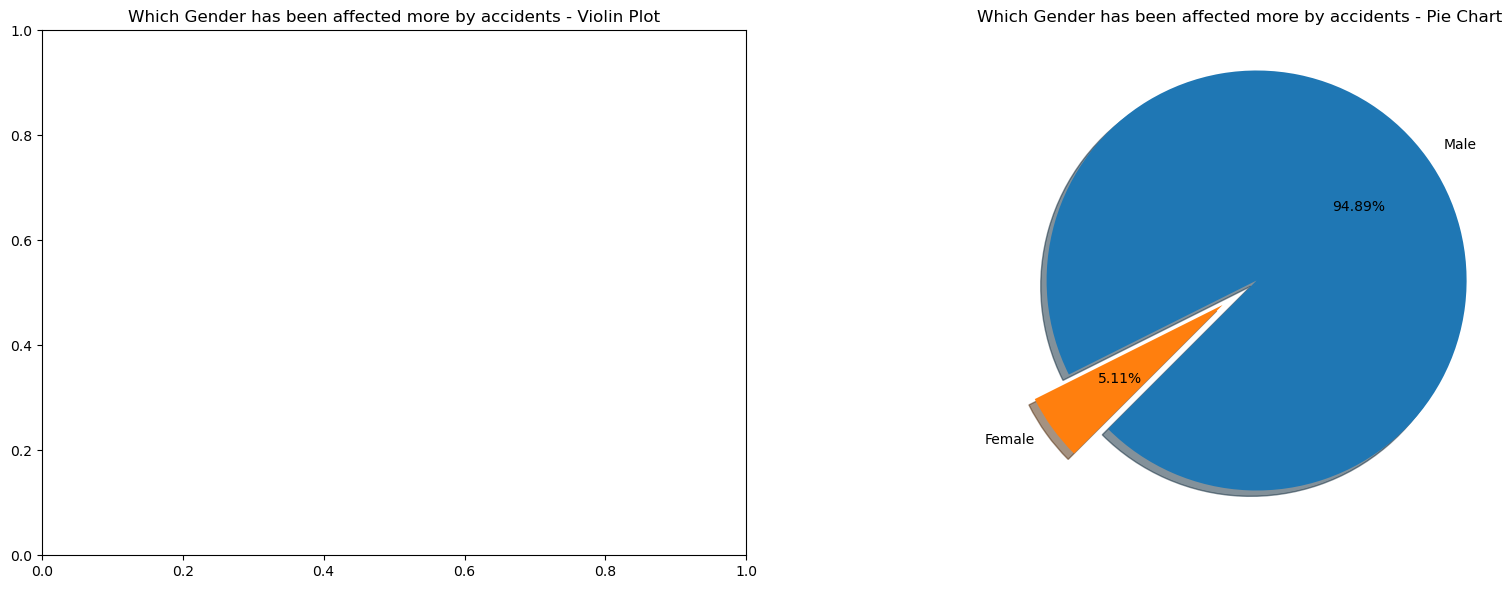

In [31]:
plot_univariate(data, 'Gender', 'Which Gender has been affected more by accidents', 'Set3')

The industry is predominantly characterized by a high proportion of male employees.

The dataset shows a significant bias towards male employees.

**Employee Type**

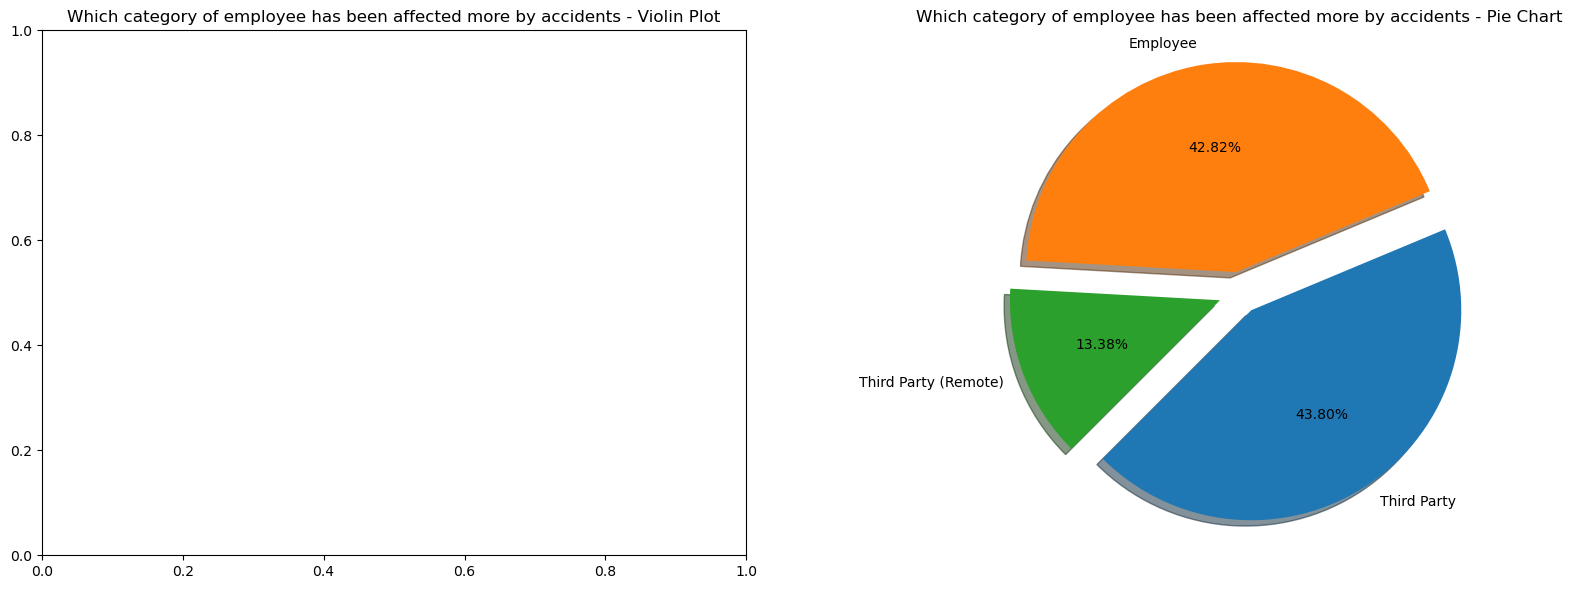

In [32]:
plot_univariate(data, 'Employee_Type', 'Which category of employee has been affected more by accidents', 'Paired')

The total number of direct employees and third-party employees is nearly equal, but there are fewer third-party remote employees.

**Country**

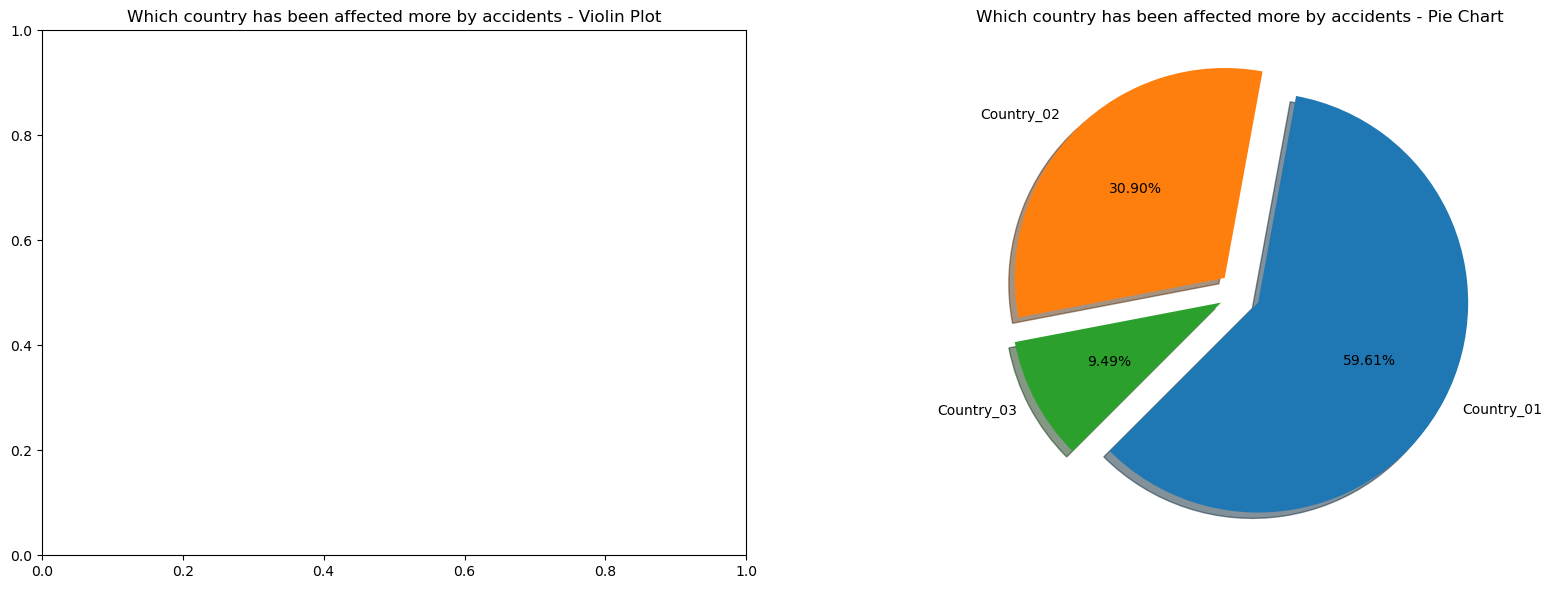

In [33]:
plot_univariate(data, 'Country', 'Which country has been affected more by accidents', 'Pastel1')


Country 1 has experienced more incidents than Country 2, while Country 3 has had fewer incidents.

**Local **

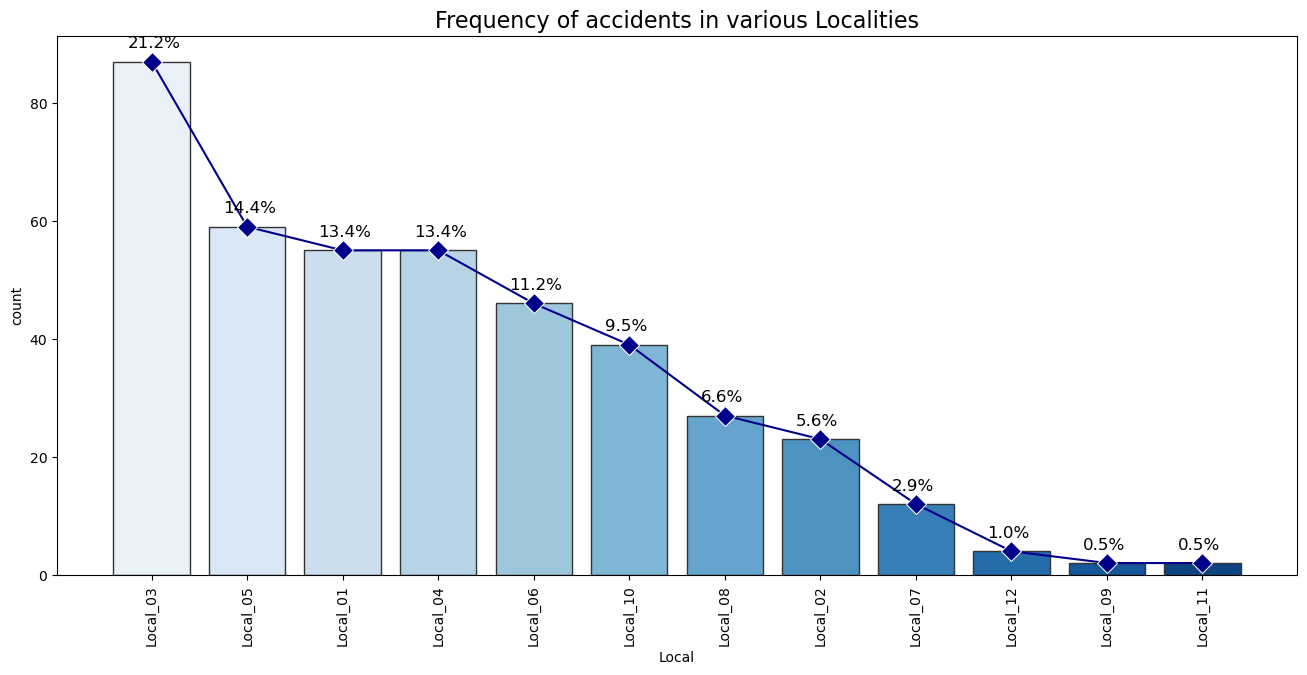

In [34]:
def plot_locals_count(df):
    plt.figure(figsize=(16, 7))

    # Changing the color palette for the bar chart
    ax = sns.countplot(x=df['Local'], order=df['Local'].value_counts().index,
                       palette='Blues', edgecolor='.2', saturation=0.9)

    # Changing the line color and marker style
    sns.lineplot(x=df['Local'].value_counts().index, y=df['Local'].value_counts().values,
                 color='darkblue', marker='D', markersize=10)

    plt.title('Frequency of accidents in various Localities', fontsize=16)
    plt.xticks(rotation='vertical')

    total = sum(df['Local'].value_counts())
    for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100 * p.get_height() / total),
                    (p.get_x(), p.get_height()),
                    size=12, xytext=(10, 10), textcoords='offset points')

    plt.show()

# Usage
plot_locals_count(data)


Local_03 has reported the highest number of accidents, accounting for approximately 21% of all incidents across the country’s plants.

This is followed by Local-05, Local-01, and others.

**Critical Risk**

C:\Users\Dinesh Chauhan\AppData\Local\Temp\ipykernel_32864\106638493.py:4: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x=df['Critical_Risk'], palette='viridis')  # Changed palette to 'viridis'
C:\Users\Dinesh Chauhan\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 39.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


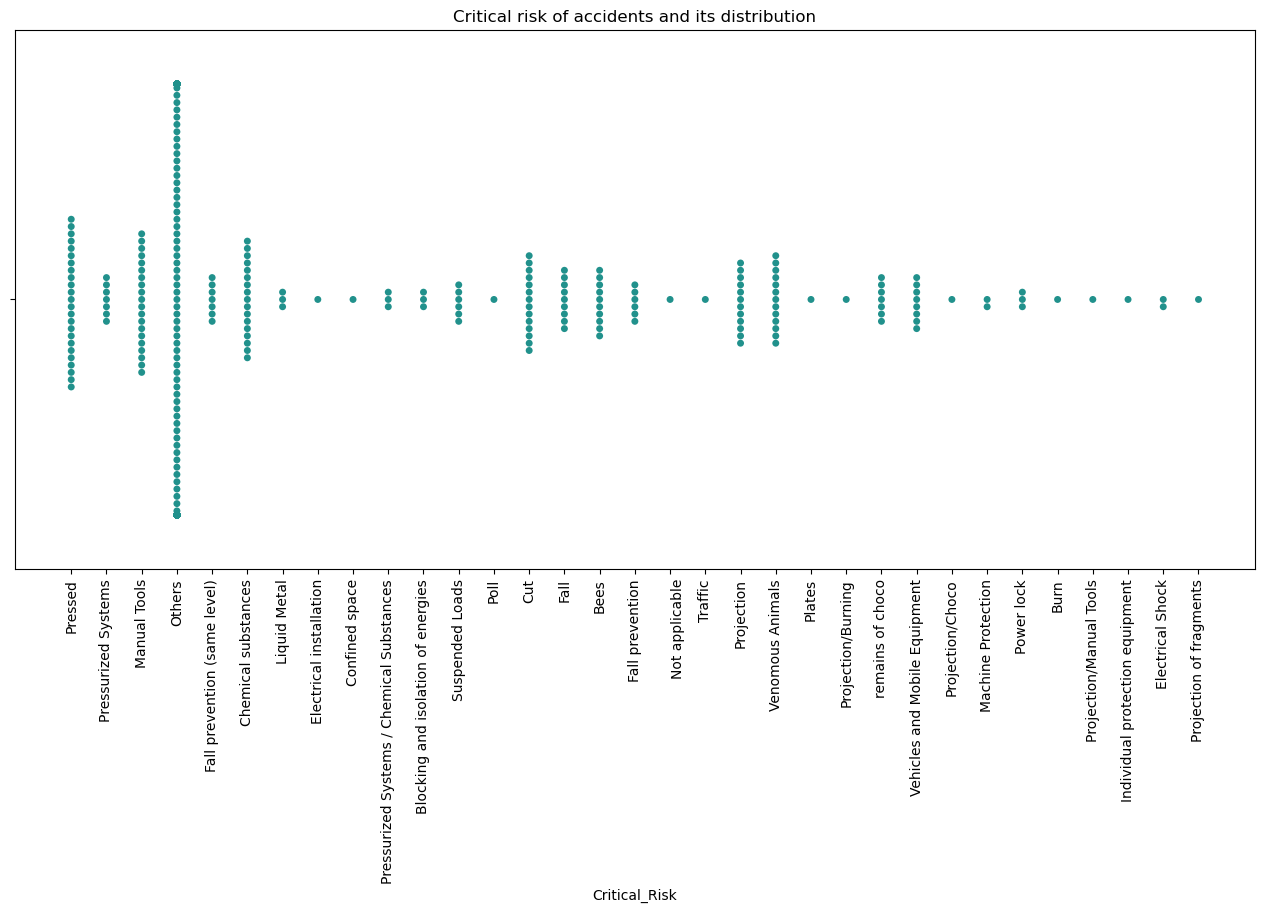

In [35]:
# Critical Risk Count with Swarm Plot
def plot_critical_risk_swarm(df):
    plt.figure(figsize=(16, 7))
    sns.swarmplot(x=df['Critical_Risk'], palette='viridis')  # Changed palette to 'viridis'
    plt.title('Critical risk of accidents and its distribution')
    plt.xticks(rotation='vertical')
    plt.show()

plot_critical_risk_swarm(data)

A significant portion of the critical risks, nearly 50% of the dataset, is classified as 'Others,' indicating a need for more precise classification of various risks.

Following this are risks categorized as Pressed, Manual tools, Chemical substances, Cut, and so on.

In [36]:
def plot_univariate_bar_pie(df, col, title, palette):
    """
    Create univariate plots with a bar plot and a pie chart.

    Parameters:
    - df: DataFrame containing the data.
    - col: Column to plot.
    - title: Title of the plot.
    - palette: Color palette for the plot.
    """
    plt.figure(figsize=(20, 15))

    # Bar plot
    plt.subplot(2, 2, 1)
    sns.barplot(x=df[col].value_counts().index, y=df[col].value_counts().values, palette=palette)
    plt.title(f'{title} - Bar Plot')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # Pie chart
    plt.subplot(2, 2, 2)
    plt.pie(df[col].value_counts(), autopct="%.2f%%", labels=df[col].value_counts().index, shadow=True,
            explode=[0.1] * len(df[col].value_counts().index), startangle=-135, colors=sns.color_palette(palette))
    plt.title(f'{title} - Pie Chart')

    plt.show()

**Accident Level**

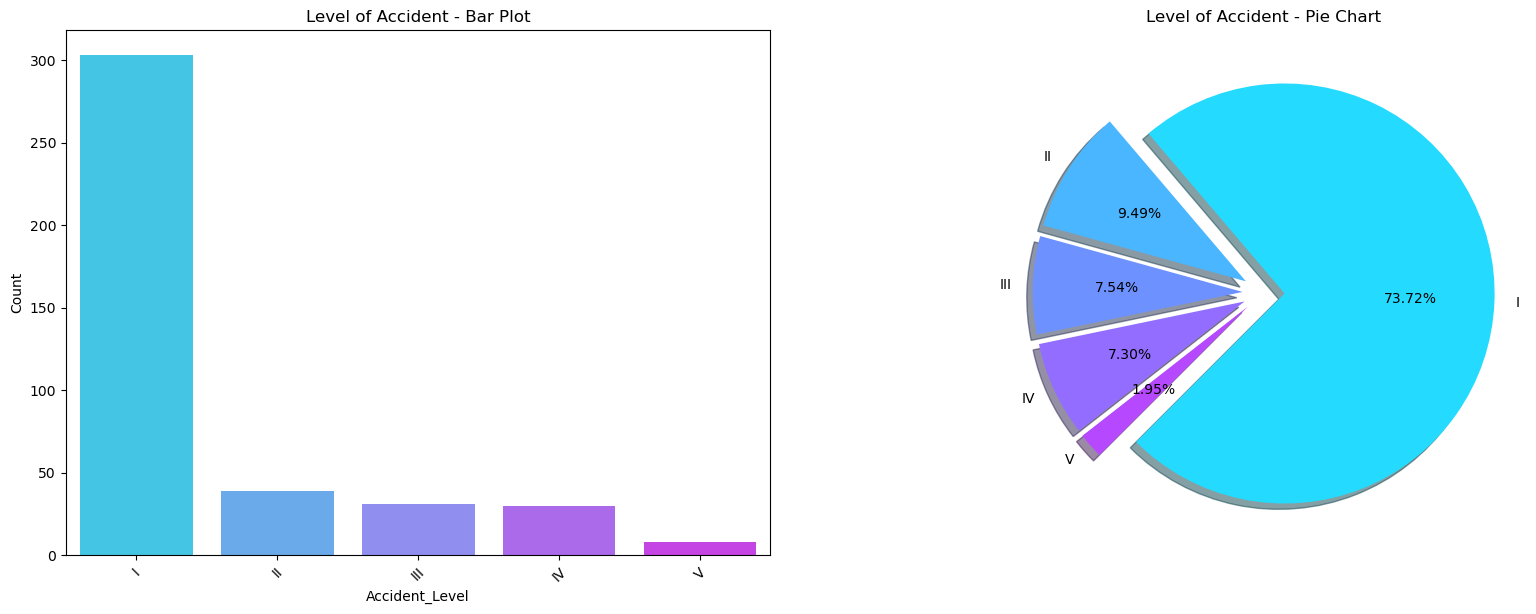

In [37]:
# Plot for 'Accident Level'
plot_univariate_bar_pie(data, 'Accident_Level', 'Level of Accident', 'cool')

Level I represents minor severity, while Level V denotes extreme severity.

Accidents categorized as Level I are the most frequent and typically involve minor issues, such as forgetting PPE or dropping a tool.

**Potential Accident Level**

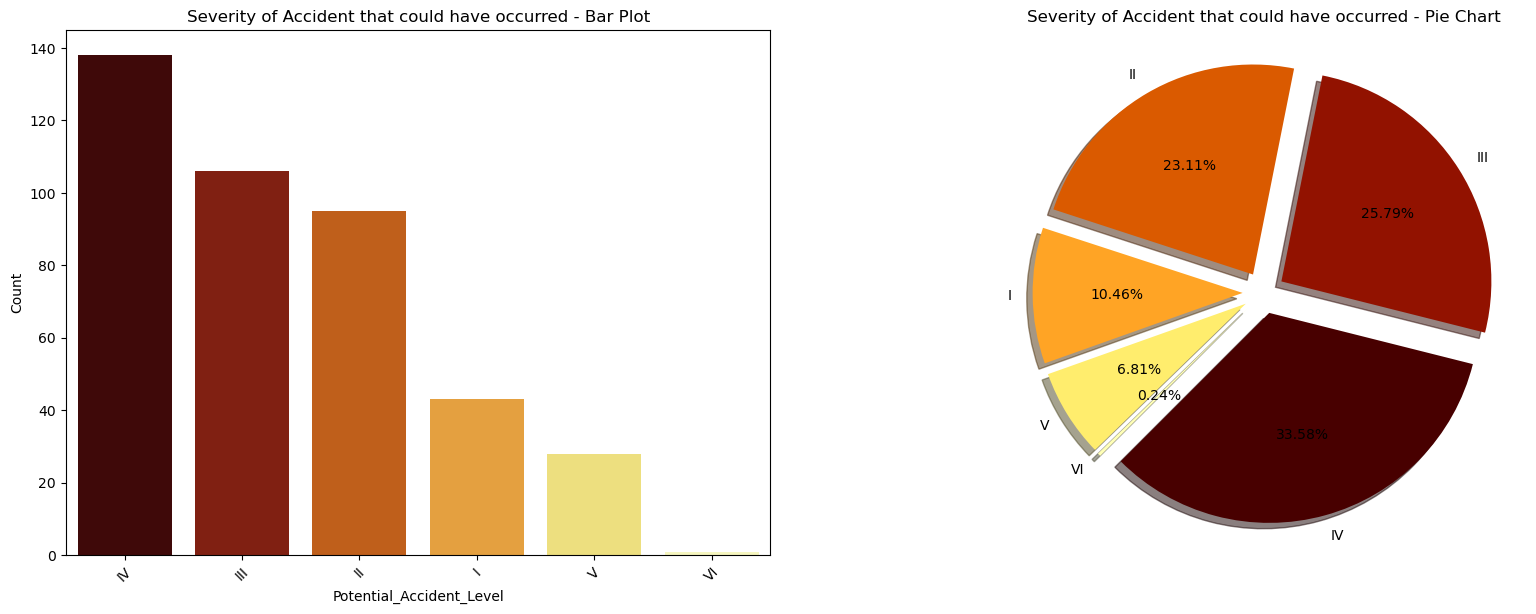

In [38]:
# Plot for 'Potential Accident Level'
plot_univariate_bar_pie(data, 'Potential_Accident_Level', 'Severity of Accident that could have occurred', 'afmhot')


The potential accident level reflects the severity of an accident based on additional factors involved.

Potential Accident Level IV has the highest count, indicating moderate severity.

It is necessary to examine the correlation between the Potential Accident Level and the Accident Level, as well as its relation to the industry sector.

**Bivariate analysis**

Bivariate Analysis on target coloumn

**Local vs. Potential Accident Level**

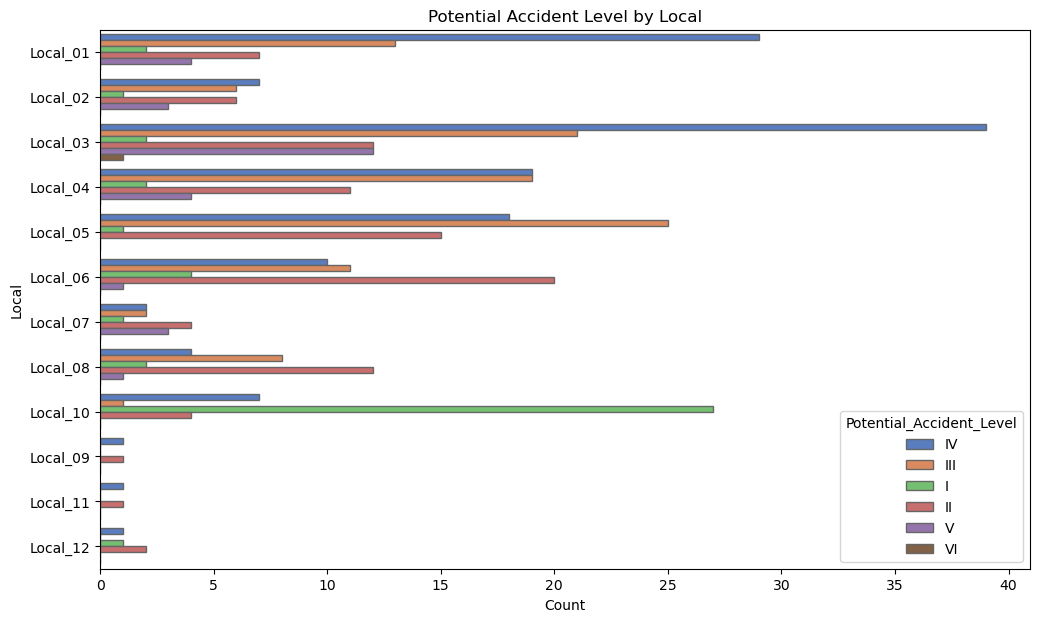

In [39]:
plt.figure(figsize=(12,7))
sns.countplot(y='Local', hue='Potential_Accident_Level', data=data, palette='muted', edgecolor='.4')
plt.title('Potential Accident Level by Local')
plt.xlabel('Count')
plt.ylabel('Local')
plt.show()


Local_03, part of Country_01, is the location with the highest frequency of accidents.

In [40]:
# Numerical Analysis:

pd.crosstab(data['Local'], data['Potential_Accident_Level'], margins=True)

Potential_Accident_Level   I  II  III   IV   V  VI  All
Local                                                  
Local_01                   2   7   13   29   4   0   55
Local_02                   1   6    6    7   3   0   23
Local_03                   2  12   21   39  12   1   87
Local_04                   2  11   19   19   4   0   55
Local_05                   1  15   25   18   0   0   59
Local_06                   4  20   11   10   1   0   46
Local_07                   1   4    2    2   3   0   12
Local_08                   2  12    8    4   1   0   27
Local_09                   0   1    0    1   0   0    2
Local_10                  27   4    1    7   0   0   39
Local_11                   0   1    0    1   0   0    2
Local_12                   1   2    0    1   0   0    4
All                       43  95  106  138  28   1  411

Local_03 has the highest number of accidents, including the most severe cases, making it the riskiest area.

Local_10 has many minor accidents (Level I) but few severe ones.

Local_05 and Local_06 also have high accident counts, mostly at moderate levels.

Local_09, Local_11, and Local_12 have very few accidents, indicating safer conditions.

Focus on Local_03 for safety improvements due to its high risk.

In [41]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(data['Local'], data['Potential_Accident_Level'])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"Chi-square Statistic: {chi2}, p-value: {p}")


Chi-square Statistic: 235.36221761186388, p-value: 3.594507833409111e-24


The extremely low p-value (much less than 0.05) suggests a statistically significant relationship between Local and Potential_Accident_Level.

This means that the distribution of accident severity levels is not random across different Local areas, indicating specific locals have distinct accident severity patterns that likely require tailored safety interventions.

**Country vs. Potential Accident Level**

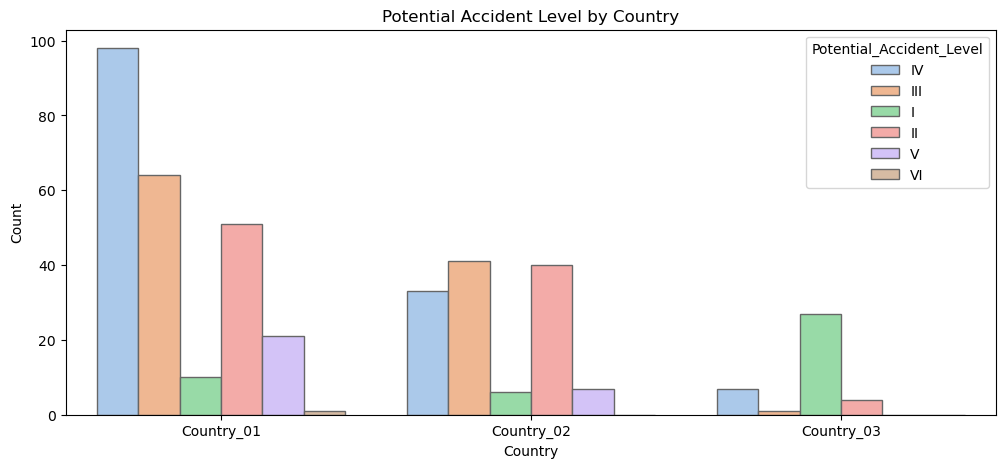

In [42]:
plt.figure(figsize=(12,5))
sns.countplot(x='Country', hue='Potential_Accident_Level', data=data, palette='pastel', edgecolor='.4')
plt.title('Potential Accident Level by Country')
plt.ylabel('Count')
plt.xlabel('Country')
plt.show()


1. Country_01 experiences a higher concentration of severe accidents, particularly at Level IV.
2. Country_02 has a balanced distribution of accidents across all severity levels.
3. Country_03 has a higher count of less severe accidents, especially at Level I, compared to Country_01 and Country_02.

In [43]:
# Numerical Analysis

pd.crosstab(data['Country'], data['Potential_Accident_Level'], margins=True)

Potential_Accident_Level   I  II  III   IV   V  VI  All
Country                                                
Country_01                10  51   64   98  21   1  245
Country_02                 6  40   41   33   7   0  127
Country_03                27   4    1    7   0   0   39
All                       43  95  106  138  28   1  411

Country_01 has the highest number of accidents (245), including the most severe ones (Level V and VI). It accounts for the majority of high-severity accidents, indicating it is the most critical area for safety interventions.

Country_02 has a moderate number of accidents (127), with a concentration in Levels II, III, and IV. It has fewer severe accidents (Level V) compared to Country_01, suggesting a more balanced but still concerning safety profile.

Country_03 has a low number of accidents (39), predominantly in Level I, indicating fewer and less severe incidents. It is relatively safer but may require attention to prevent the escalation of minor incidents.

In [44]:
# Statistical Testing

contingency_table = pd.crosstab(data['Country'], data['Potential_Accident_Level'])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"Chi-square Statistic: {chi2}, p-value: {p}")

Chi-square Statistic: 172.51781076583225, p-value: 8.348502170052156e-32


The extremely low p-value indicates a statistically significant relationship between Country and Potential_Accident_Level.

This means that accident severity levels vary significantly across the different countries, highlighting the need for country-specific safety strategies and interventions.

**Industry Sector vs. Potential Accident Level**

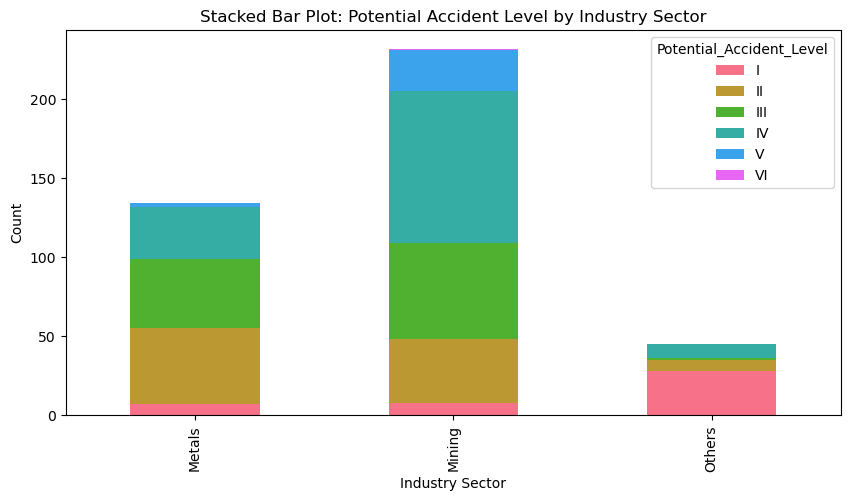

In [45]:
data.groupby(['Industry_Sector', 'Potential_Accident_Level']).size().unstack().plot(kind='bar', stacked=True, figsize=(10,5), color=sns.color_palette('husl'))
plt.title('Stacked Bar Plot: Potential Accident Level by Industry Sector')
plt.ylabel('Count')
plt.xlabel('Industry Sector')
plt.show()


* The Mining Industry has experienced the most severe accidents, with the highest corresponding potential accident levels.
* The Metal industry follows, with other industries having fewer severe incidents.
* The Mining sector shows a higher rate of Level IV accidents, slightly surpassing Level II and III incidents in severity.

In [46]:
# Numerical Analysis

industry_accidents = pd.crosstab(data['Industry_Sector'], data['Potential_Accident_Level'], margins=True)
print(industry_accidents)

Potential_Accident_Level   I  II  III   IV   V  VI  All
Industry_Sector                                        
Metals                     7  48   44   33   2   0  134
Mining                     8  40   61   96  26   1  232
Others                    28   7    1    9   0   0   45
All                       43  95  106  138  28   1  411


Mining is the top priority for safety improvements due to its high overall and severe accident counts.

Metals should enhance safety measures to reduce moderate-level accidents.

Others appears safer but should maintain safety practices to avoid potential future issues.

In [47]:
# Statistical Testing

chi2, p, dof, ex = chi2_contingency(industry_accidents.iloc[:-1, :-1])  # Exclude the 'All' row and column
print(f"Chi-square Statistic: {chi2}, p-value: {p}")


Chi-square Statistic: 181.73738344191983, p-value: 1.0209410384588079e-33


The extremely low p-value indicates a statistically significant difference in accident severity levels across industry sectors.

This suggests that the distribution of accident severity varies considerably between different industry sectors, highlighting the need for sector-specific safety strategies and interventions.

4. Gender vs. Potential Accident Level

C:\Users\Dinesh Chauhan\AppData\Local\Temp\ipykernel_32864\2540117252.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='Gender', y='Potential_Accident_Level', data=data, palette='Set2', jitter=True, edgecolor='.4')


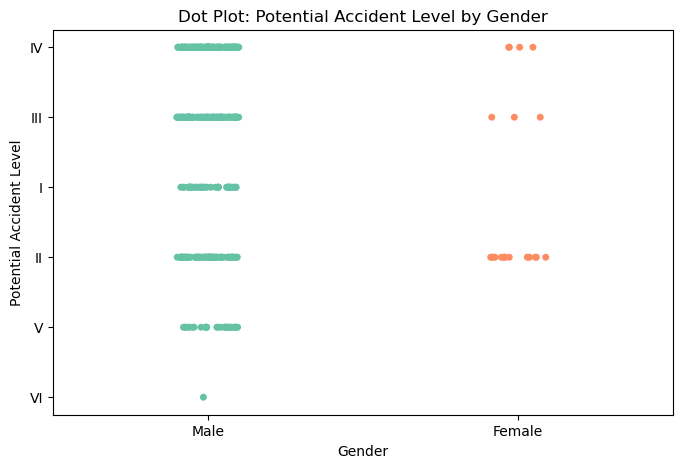

In [48]:
plt.figure(figsize=(8,5))
sns.stripplot(x='Gender', y='Potential_Accident_Level', data=data, palette='Set2', jitter=True, edgecolor='.4')
plt.title('Dot Plot: Potential Accident Level by Gender')
plt.xlabel('Gender')
plt.ylabel('Potential Accident Level')
plt.show()


Males are predominantly involved in more severe accidents, while females are more frequently associated with less severe accidents, particularly at Level II.

In [49]:
# Numerical Analysis
gender_accidents = pd.crosstab(data['Gender'], data['Potential_Accident_Level'], margins=True)
print(gender_accidents)

Potential_Accident_Level   I  II  III   IV   V  VI  All
Gender                                                 
Female                     0  14    3    4   0   0   21
Male                      43  81  103  134  28   1  390
All                       43  95  106  138  28   1  411


Male employees are at a higher risk for accidents and more severe accident levels compared to females.

Female employees have fewer accidents and lower severity, suggesting a need for targeted interventions to address higher accident rates among males.

In [50]:
# Statistical Testing

chi2, p, dof, ex = chi2_contingency(gender_accidents.iloc[:-1, :-1])  # Exclude 'All' row and column
print(f"Chi-square Statistic: {chi2}, p-value: {p}")


Chi-square Statistic: 24.56496792084331, p-value: 0.0001690321312212402


The very low p-value indicates a statistically significant difference in accident severity levels between genders.

This suggests that gender significantly influences the distribution of accident severity, with males experiencing more severe accidents compared to females.

**Employee Type vs. Potential Accident Level**

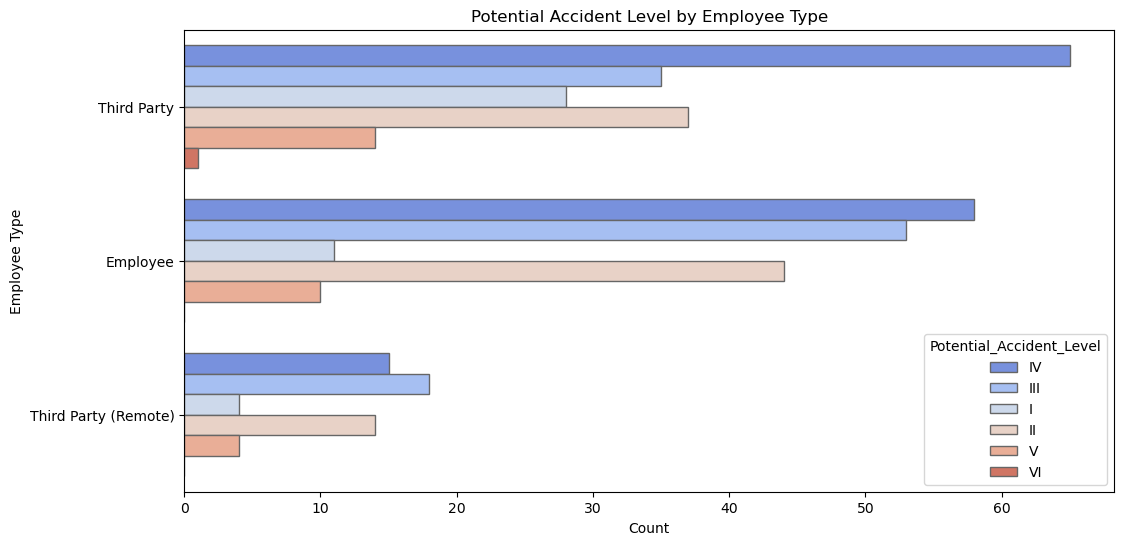

In [51]:
plt.figure(figsize=(12,6))
sns.countplot(y='Employee_Type', hue='Potential_Accident_Level', data=data, palette='coolwarm', edgecolor='.4')
plt.title('Potential Accident Level by Employee Type')
plt.xlabel('Count')
plt.ylabel('Employee Type')
plt.show()



* Third-party employees are more frequently involved in accidents.
* Besides Accident Level I, employees are also encountering severe accidents, particularly at Accident Level IV, in the industry.

In [52]:
# Numerical Analysis
employee_accidents = pd.crosstab(data['Employee_Type'], data['Potential_Accident_Level'], margins=True)
print(employee_accidents)

Potential_Accident_Level   I  II  III   IV   V  VI  All
Employee_Type                                          
Employee                  11  44   53   58  10   0  176
Third Party               28  37   35   65  14   1  180
Third Party (Remote)       4  14   18   15   4   0   55
All                       43  95  106  138  28   1  411


Third Party is the highest priority for safety interventions due to the high total number of accidents and higher severity levels.

Employee experiences a moderate number of accidents with fewer severe incidents, suggesting a need for focused safety measures to address moderate-risk areas.

Third Party (Remote) appears safer but should still be monitored to maintain safety standards.

In [53]:
# Statistical Testing

chi2, p, dof, ex = chi2_contingency(employee_accidents.iloc[:-1, :-1])  # Exclude 'All' row and column
print(f"Chi-square Statistic: {chi2}, p-value: {p}")

Chi-square Statistic: 16.89845575822984, p-value: 0.07664131046907577


The p-value of 0.077 is slightly above the conventional significance level of 0.05. This means that the result is not statistically significant at the 5% level.

It implies that there is not strong enough evidence to reject the null hypothesis, suggesting that the differences in accident severity across Employee_Type categories are not statistically significant.

**Critical Risk vs. Potential Accident Level**

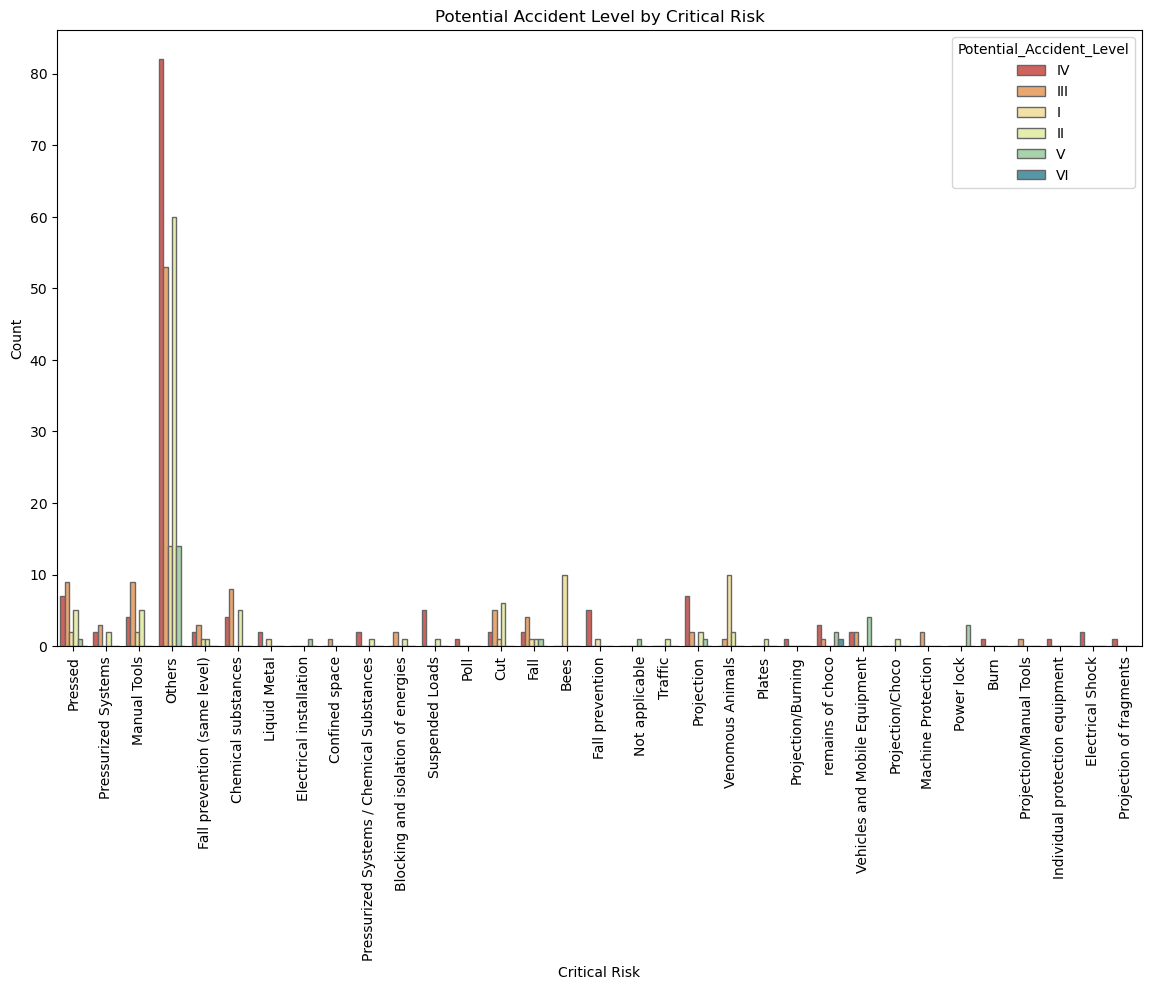

In [54]:
plt.figure(figsize=(14,8))
sns.countplot(x='Critical_Risk', hue='Potential_Accident_Level', data=data, palette='Spectral', edgecolor='.4')
plt.title('Potential Accident Level by Critical Risk')
plt.ylabel('Count')
plt.xlabel('Critical Risk')
plt.xticks(rotation=90)
plt.show()


The "Others" category in Critical Risk shows a higher concentration of incidents with severe Potential Accident Levels, indicating a significant risk associated with these unspecified or miscellaneous factors.

In [55]:
# Numerical Analysis:
critical_risk_accidents = pd.crosstab(data['Critical_Risk'], data['Potential_Accident_Level'], margins=True)
print(critical_risk_accidents)

Potential_Accident_Level                    I  II  III   IV   V  VI  All
Critical_Risk                                                           
\nNot applicable                            0   0    0    0   1   0    1
Bees                                       10   0    0    0   0   0   10
Blocking and isolation of energies          0   1    2    0   0   0    3
Burn                                        0   0    0    1   0   0    1
Chemical substances                         0   5    8    4   0   0   17
Confined space                              0   0    1    0   0   0    1
Cut                                         1   6    5    2   0   0   14
Electrical Shock                            0   0    0    2   0   0    2
Electrical installation                     0   0    0    0   1   0    1
Fall                                        1   1    4    2   1   0    9
Fall prevention                             1   0    0    5   0   0    6
Fall prevention (same level)                1   1  

High-risk areas include categories like Others and Manual Tools, which contribute significantly to accident severity.

Low-risk areas are generally those with fewer severe incidents, such as Bees and Burn.

Monitoring and safety interventions should prioritize high-severity categories while ensuring that low-risk factors are not neglected.

In [56]:
# Statistical Testing

chi2, p, dof, ex = chi2_contingency(critical_risk_accidents.iloc[:-1, :-1])  # Exclude 'All' row and column
print(f"Chi-square Statistic: {chi2}, p-value: {p}")


Chi-square Statistic: 402.803215742986, p-value: 6.543004501368816e-23


The p-value is extremely low (much less than 0.05), indicating that the result is highly statistically significant.

This suggests a strong association between Critical_Risk and Potential_Accident_Level, meaning that the severity of accidents is significantly influenced by the critical risk factor.

C:\Users\Dinesh Chauhan\AppData\Local\Temp\ipykernel_32864\3891512782.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_encoded.corr()


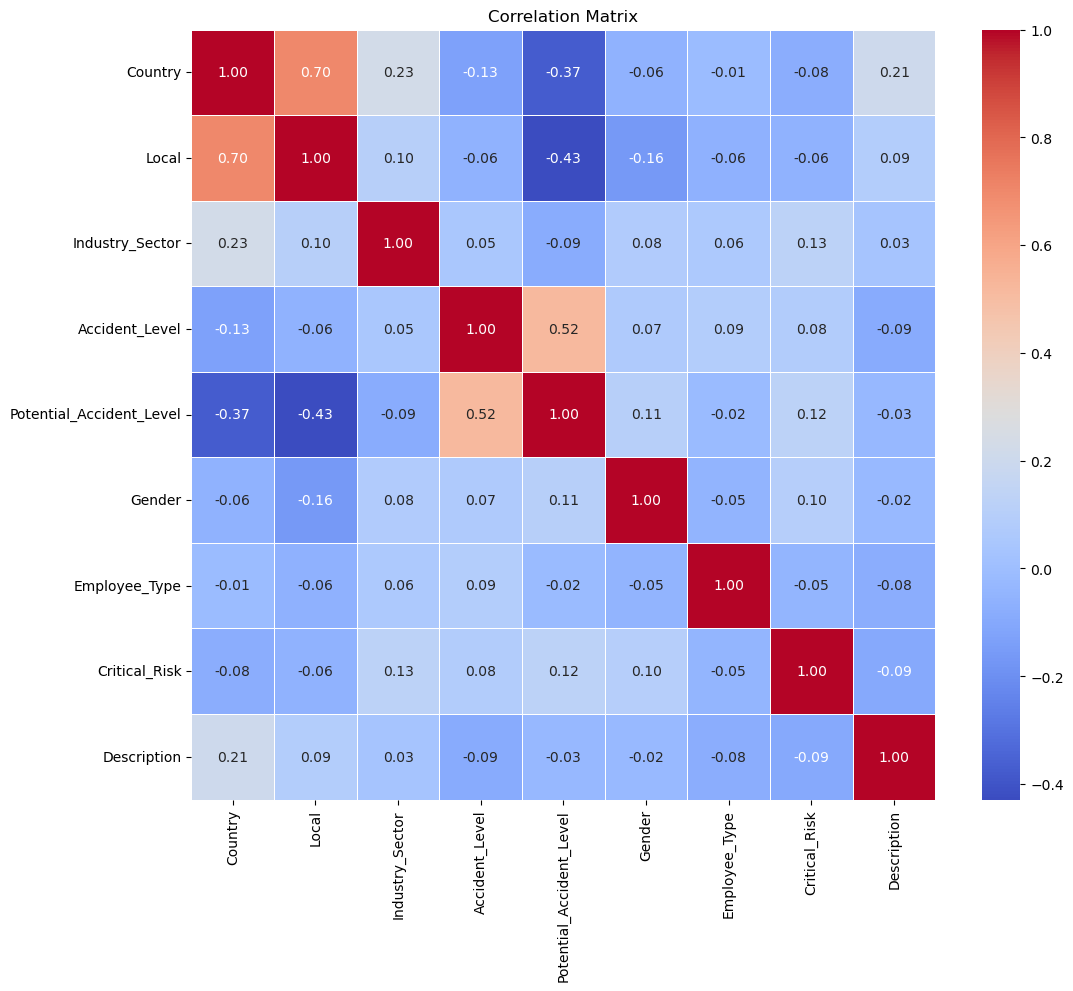

In [57]:
# Step 1: Convert categorical variables to numeric
def encode_categorical(data):
    le = LabelEncoder()
    data_encoded = data.copy()
    for column in data_encoded.select_dtypes(include=['object']).columns:
        data_encoded[column] = le.fit_transform(data_encoded[column])
    return data_encoded

# Step 2: Compute the correlation matrix
def plot_correlation_matrix(data):
    data_encoded = encode_categorical(data)
    correlation_matrix = data_encoded.corr()

    # Step 3: Plot the correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

# usage
plot_correlation_matrix(data)


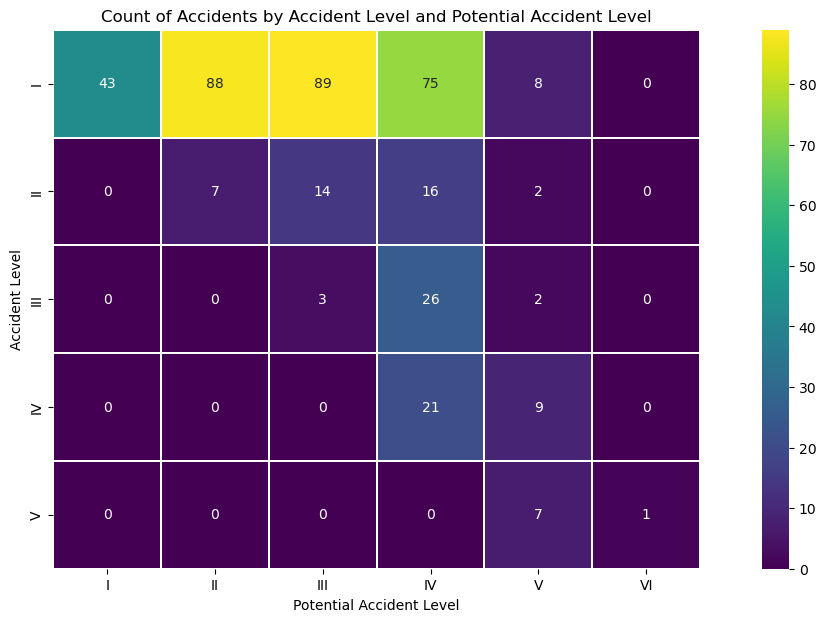

In [58]:
# Create a heatmap to show counts of accidents
plt.figure(figsize=(16, 7))
sns.heatmap(pd.crosstab(data['Accident_Level'], data['Potential_Accident_Level']),
            square=True,
            cmap='viridis',  # Change to desired colormap
            annot=True,
            linewidths=0.1)
plt.title('Count of Accidents by Accident Level and Potential Accident Level')
plt.xlabel('Potential Accident Level')
plt.ylabel('Accident Level')
plt.show()



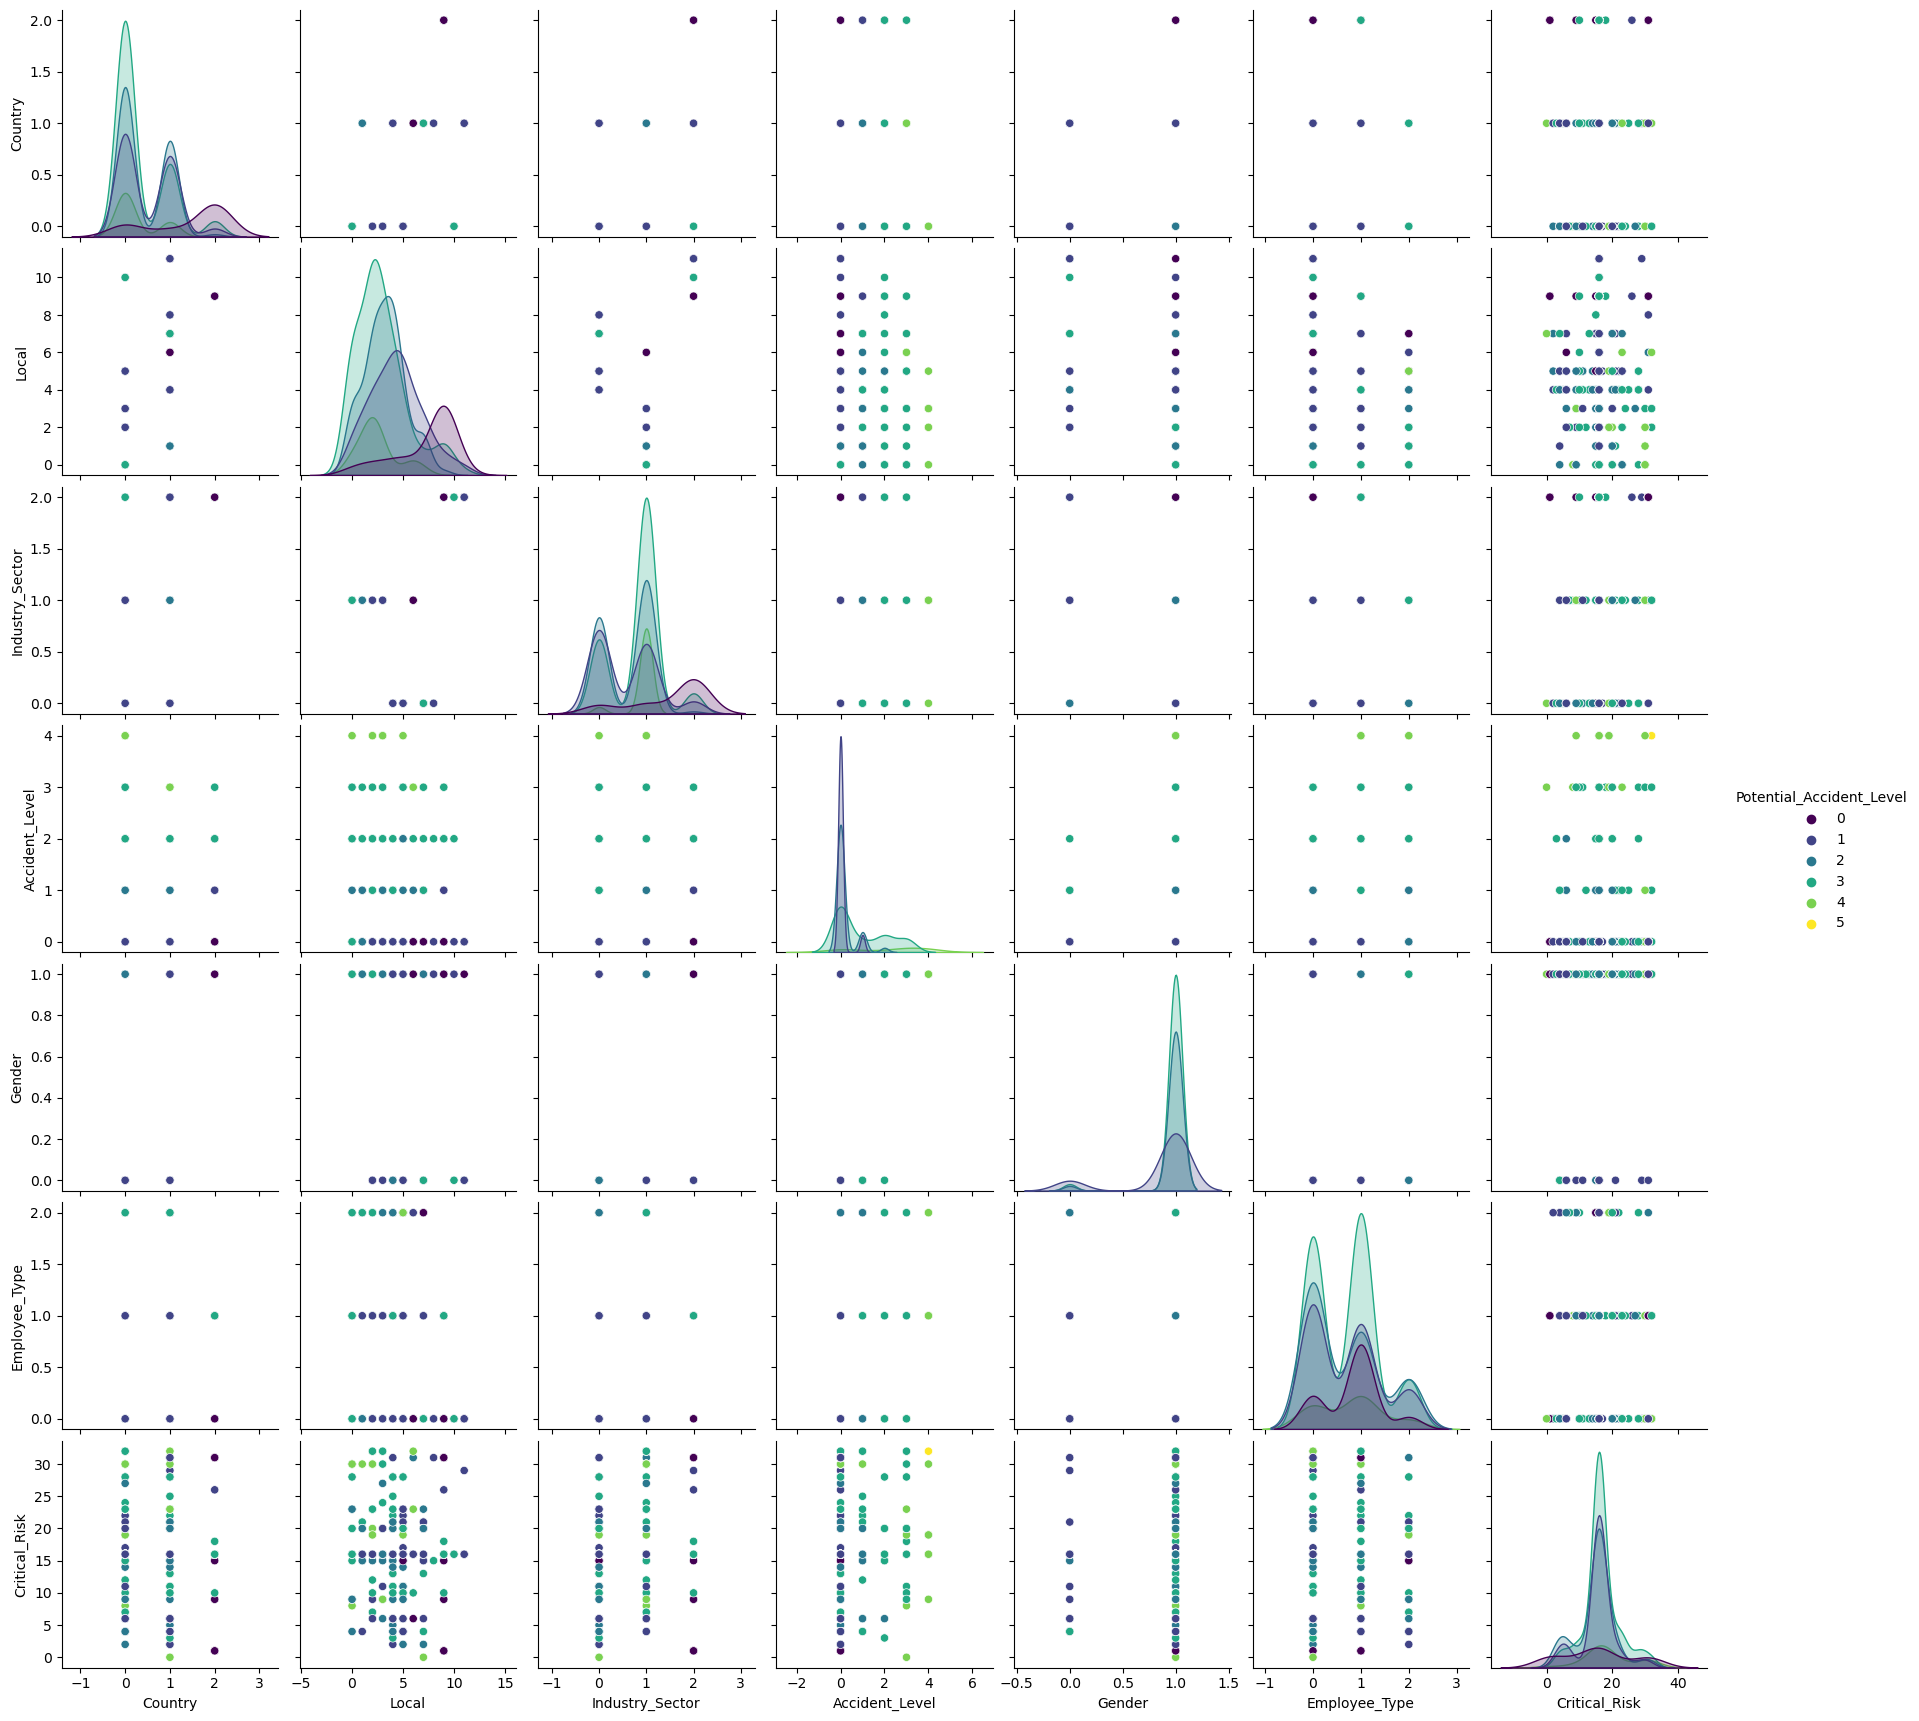

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# If you have categorical variables, encode them to numeric for pairplot
data_encoded = data.copy()
for col in ['Country', 'Local', 'Industry_Sector', 'Accident_Level', 'Potential_Accident_Level', 'Gender', 'Employee_Type', 'Critical_Risk']:
    data_encoded[col] = data_encoded[col].astype('category').cat.codes

# Pairplot to visualize relationships between variables
sns.pairplot(data_encoded, diag_kind='kde', hue='Potential_Accident_Level', palette='viridis')
plt.show()


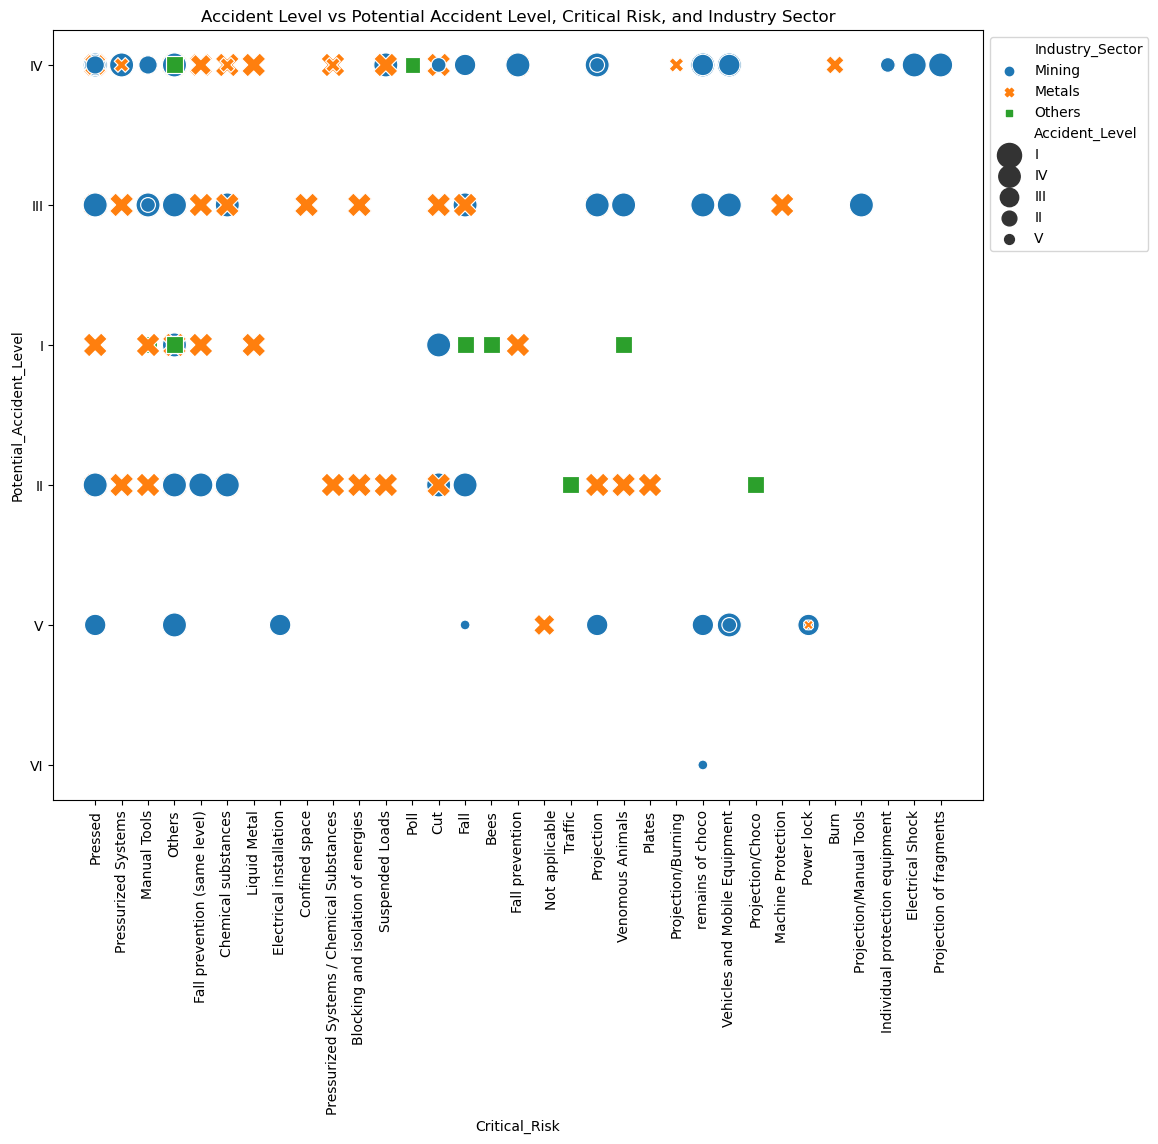

In [60]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(
    x="Critical_Risk", y="Potential_Accident_Level",
    hue="Industry_Sector", style="Industry_Sector",
    size="Accident_Level", sizes=(50, 300),
    data=data, palette='tab10', ax=ax
)

ax.set_title("Accident Level vs Potential Accident Level, Critical Risk, and Industry Sector")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation='vertical')
plt.show()


**Mining Industry:** The Mining Industry has experienced the highest number of severe accidents, with corresponding high potential accident levels.

**Accident Distribution:** The majority of accidents come from the Mining Industry, primarily of moderate severity, followed by the Metal industry and other sectors.

**Accident Levels:** The severity of accidents (Accident Level) closely matches the potential severity (Potential Accident Level).

**Critical Risks:** Some critical risks, despite being less severe, have recorded a significant number of accidents.

**Association of all variables with Accident_Level and Potential_Accident_Level**

Chi-Square Test for Country vs Accident_Level: Chi2 Stat = 15.37, p-value = 0.0524
Chi-Square Test for Country vs Potential_Accident_Level: Chi2 Stat = 172.52, p-value = 0.0000
Chi-Square Test for Local vs Accident_Level: Chi2 Stat = 56.71, p-value = 0.0947
Chi-Square Test for Local vs Potential_Accident_Level: Chi2 Stat = 235.36, p-value = 0.0000
Chi-Square Test for Industry_Sector vs Accident_Level: Chi2 Stat = 10.55, p-value = 0.2287
Chi-Square Test for Industry_Sector vs Potential_Accident_Level: Chi2 Stat = 181.74, p-value = 0.0000
Chi-Square Test for Gender vs Accident_Level: Chi2 Stat = 2.97, p-value = 0.5634
Chi-Square Test for Gender vs Potential_Accident_Level: Chi2 Stat = 24.56, p-value = 0.0002
Chi-Square Test for Employee_Type vs Accident_Level: Chi2 Stat = 9.38, p-value = 0.3109
Chi-Square Test for Employee_Type vs Potential_Accident_Level: Chi2 Stat = 16.90, p-value = 0.0766


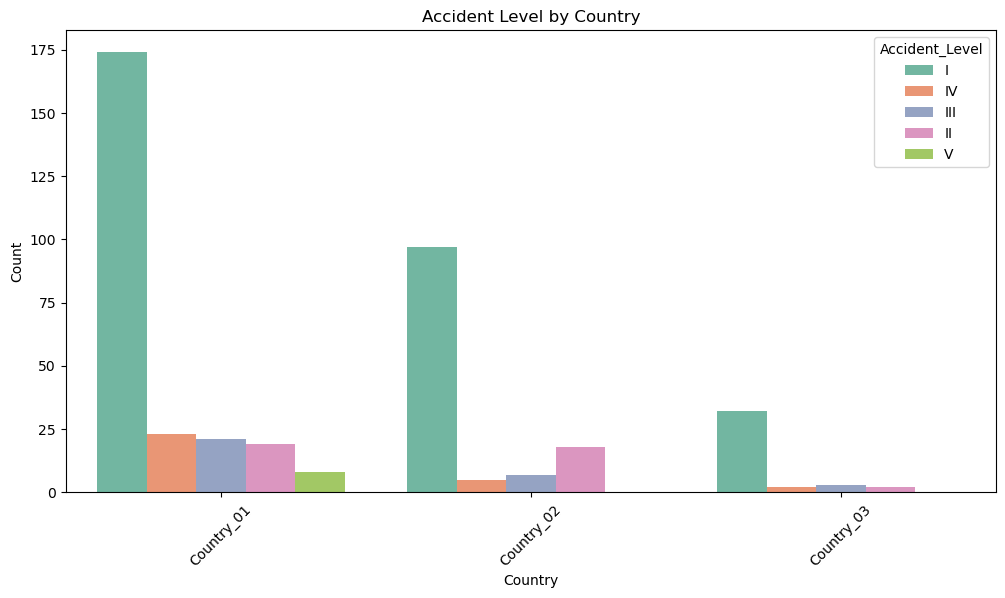

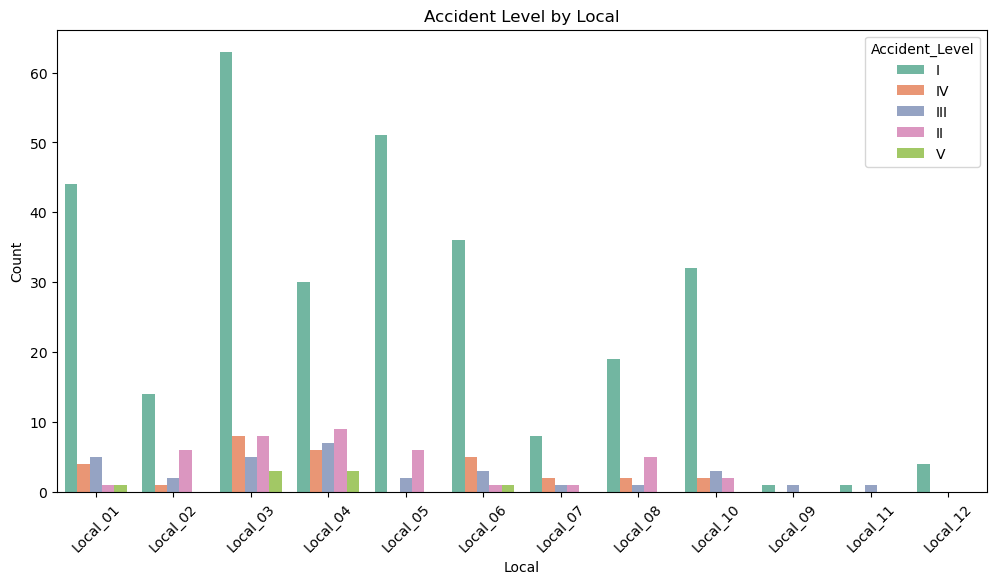

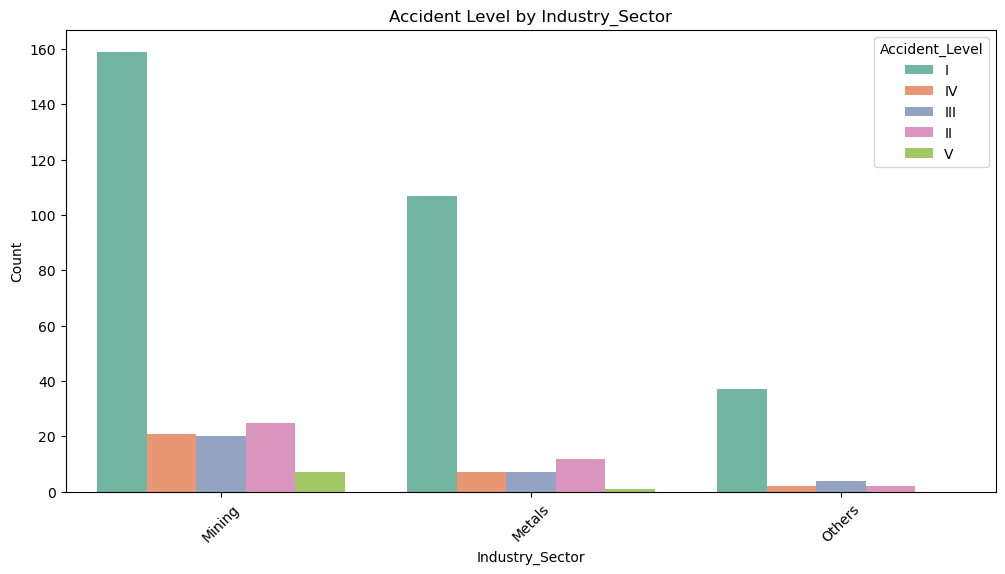

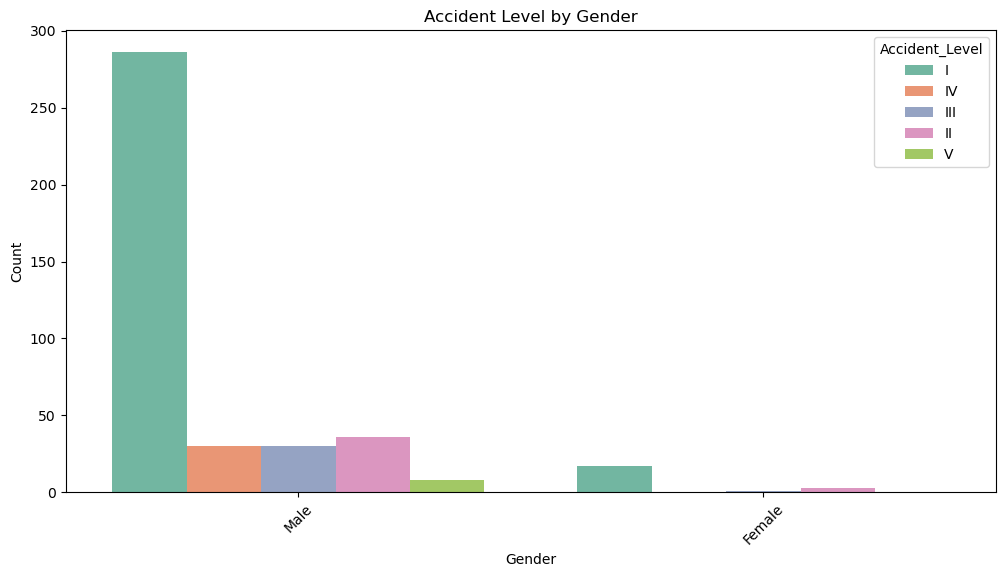

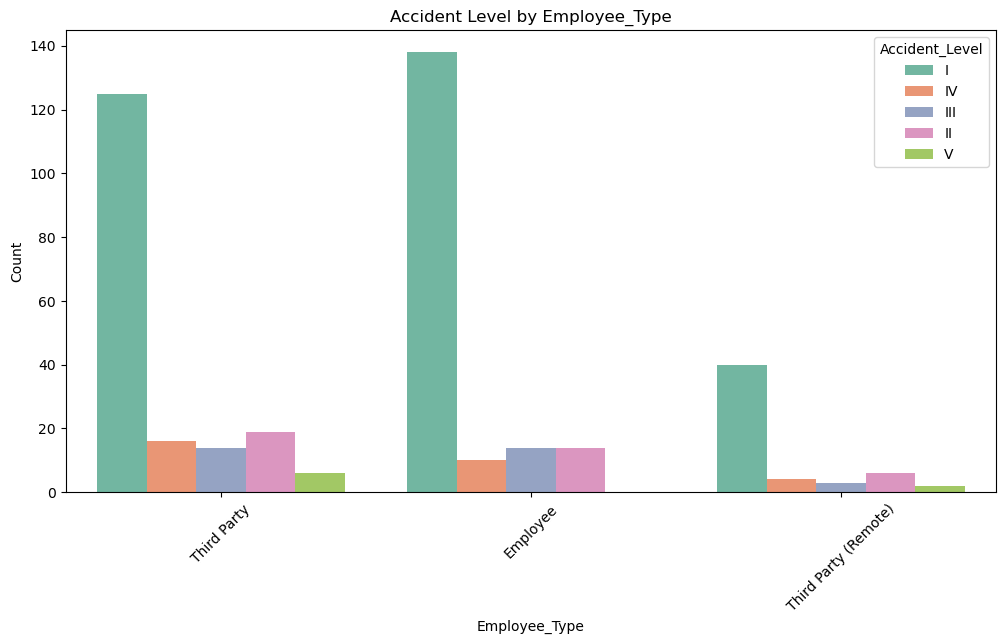

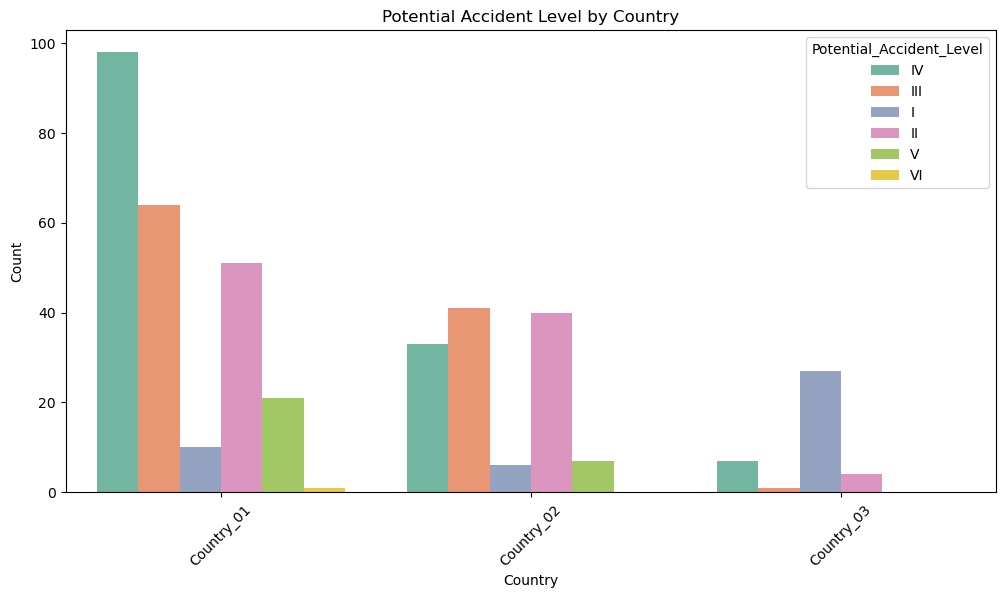

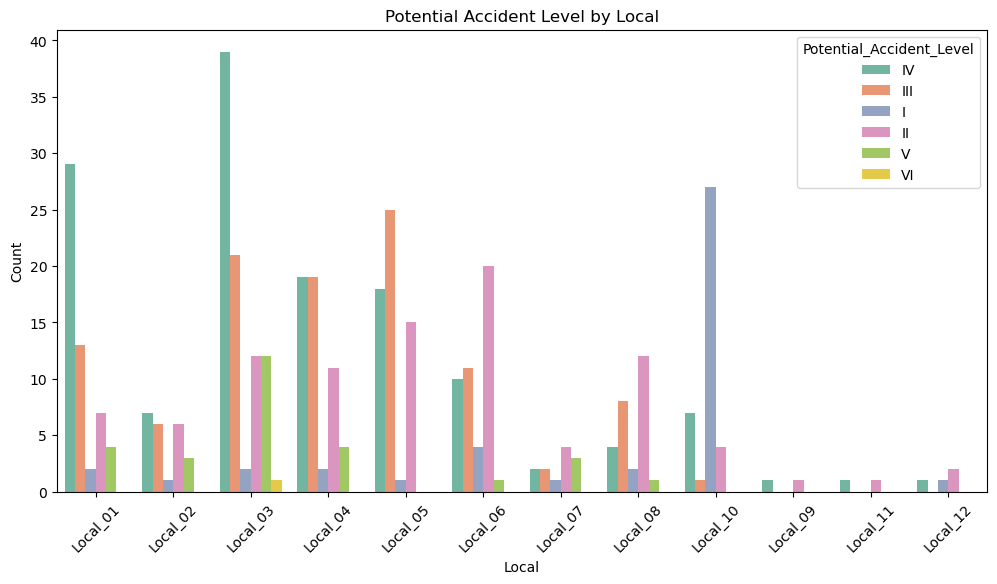

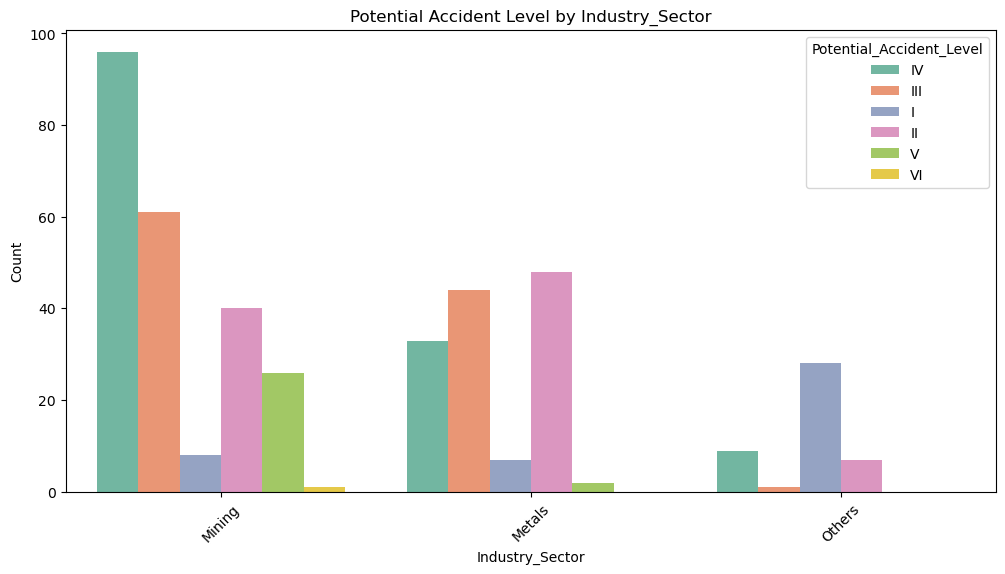

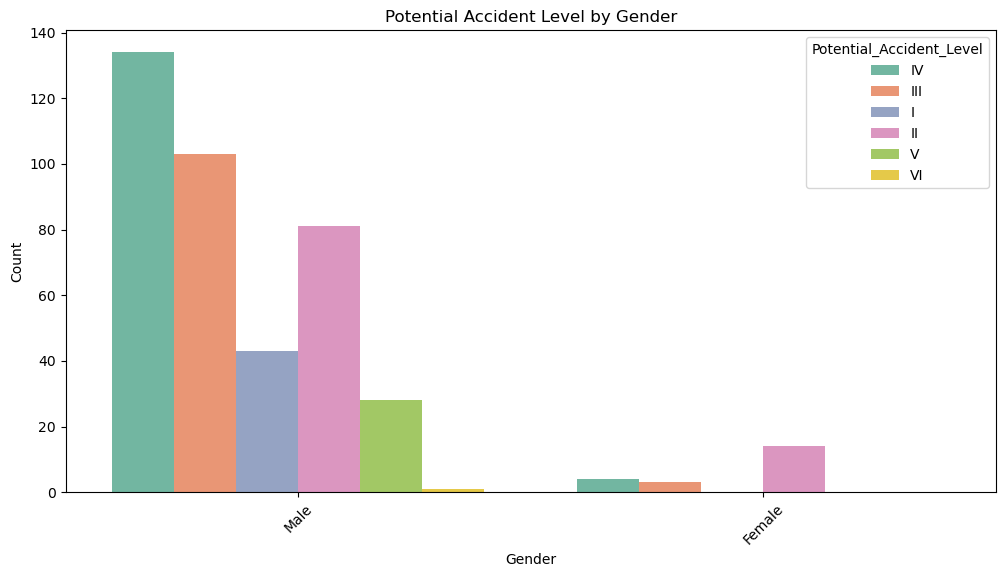

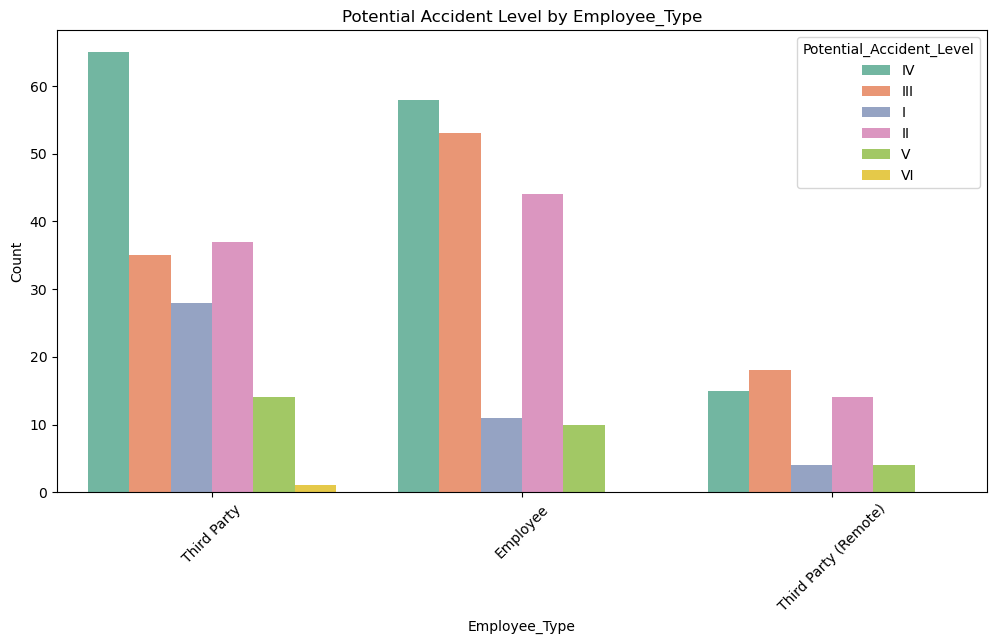

In [61]:
# data encoding
data_encoded = data.copy()
for col in ['Country', 'Local', 'Industry_Sector', 'Gender', 'Employee_Type']:
    data_encoded[col] = data_encoded[col].astype('category').cat.codes

# Function to perform chi-square test
def chi_square_test(data, var1, var2):
    contingency_table = pd.crosstab(data[var1], data[var2])
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
    return chi2_stat, p_value

# Perform chi-square test for each categorical variable with Accident_Level and Potential_Accident_Level
categorical_vars = ['Country', 'Local', 'Industry_Sector', 'Gender', 'Employee_Type']
for var in categorical_vars:
    chi2_stat_acc, p_value_acc = chi_square_test(data_encoded, var, 'Accident_Level')
    chi2_stat_potential_acc, p_value_potential_acc = chi_square_test(data_encoded, var, 'Potential_Accident_Level')

    print(f"Chi-Square Test for {var} vs Accident_Level: Chi2 Stat = {chi2_stat_acc:.2f}, p-value = {p_value_acc:.4f}")
    print(f"Chi-Square Test for {var} vs Potential_Accident_Level: Chi2 Stat = {chi2_stat_potential_acc:.2f}, p-value = {p_value_potential_acc:.4f}")

# Visualize categorical variables with Accident_Level
for var in categorical_vars:
    plt.figure(figsize=(12,6))
    sns.countplot(data=data, x=var, hue='Accident_Level', palette='Set2')
    plt.title(f'Accident Level by {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Visualize categorical variables with Potential_Accident_Level
for var in categorical_vars:
    plt.figure(figsize=(12,6))
    sns.countplot(data=data, x=var, hue='Potential_Accident_Level', palette='Set2')
    plt.title(f'Potential Accident Level by {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()


Chi-Square Test for Critical_Risk vs Accident_Level: Chi2 Stat = 214.88, p-value = 0.0000
Chi-Square Test for Critical_Risk vs Potential_Accident_Level: Chi2 Stat = 402.80, p-value = 0.0000


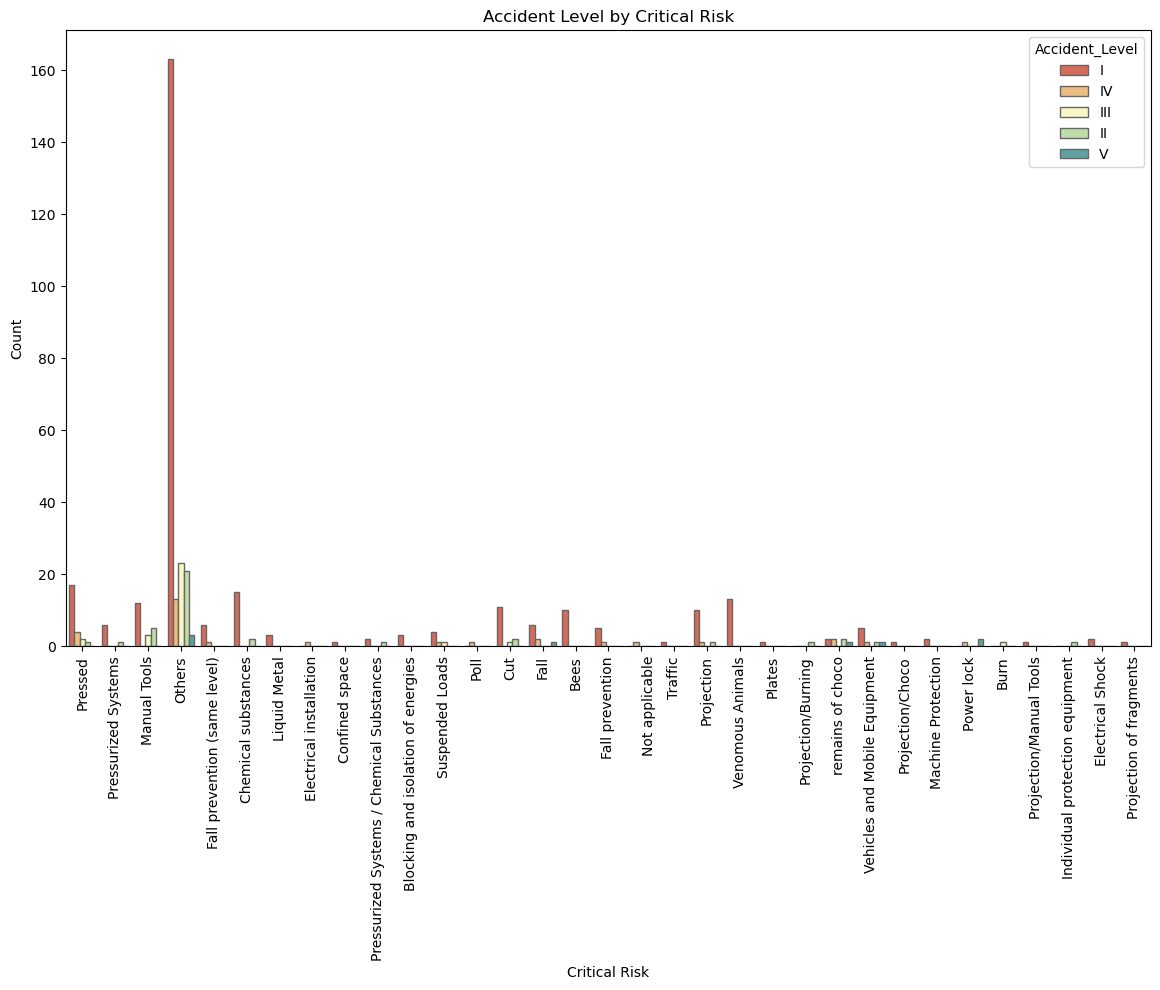

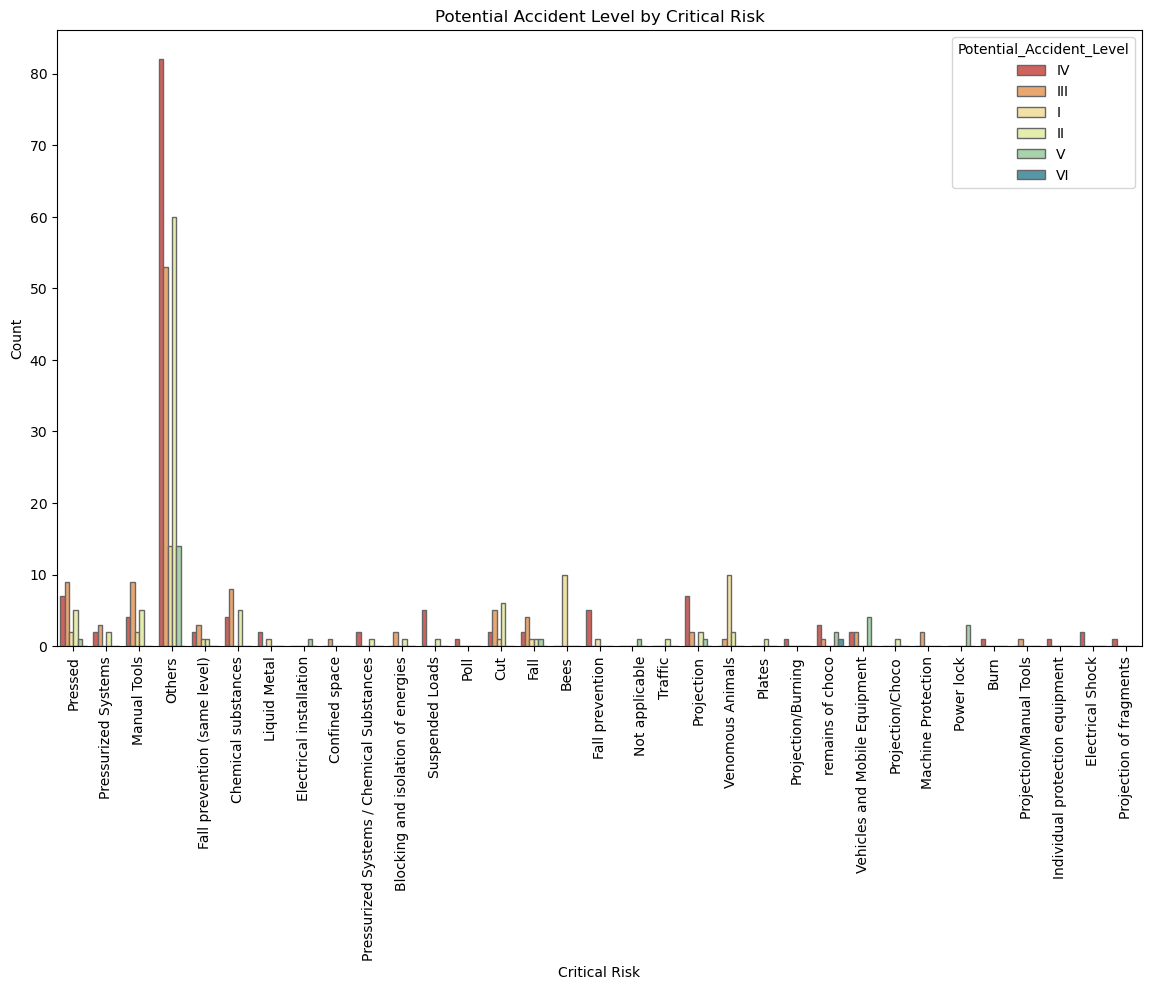

In [62]:
def analyze_critical_risk(data):
    # Copy the data
    data_encoded = data.copy()

    # Encode 'Critical_Risk' variable
    data_encoded['Critical_Risk_Encoded'] = data_encoded['Critical_Risk'].astype('category').cat.codes

    # Function to perform chi-square test
    def chi_square_test(data, var1, var2):
        contingency_table = pd.crosstab(data[var1], data[var2])
        chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
        return chi2_stat, p_value

    # Perform chi-square test for Critical_Risk with Accident_Level and Potential_Accident_Level
    chi2_stat_risk_acc, p_value_risk_acc = chi_square_test(data_encoded, 'Critical_Risk_Encoded', 'Accident_Level')
    chi2_stat_risk_potential_acc, p_value_risk_potential_acc = chi_square_test(data_encoded, 'Critical_Risk_Encoded', 'Potential_Accident_Level')

    print(f"Chi-Square Test for Critical_Risk vs Accident_Level: Chi2 Stat = {chi2_stat_risk_acc:.2f}, p-value = {p_value_risk_acc:.4f}")
    print(f"Chi-Square Test for Critical_Risk vs Potential_Accident_Level: Chi2 Stat = {chi2_stat_risk_potential_acc:.2f}, p-value = {p_value_risk_potential_acc:.4f}")

    # Visualization for Critical_Risk with Accident_Level
    plt.figure(figsize=(14, 8))
    sns.countplot(x='Critical_Risk', hue='Accident_Level', data=data, palette='Spectral', edgecolor='.4')
    plt.title('Accident Level by Critical Risk')
    plt.ylabel('Count')
    plt.xlabel('Critical Risk')
    plt.xticks(rotation=90)
    plt.show()

    # Visualization for Critical_Risk with Potential_Accident_Level
    plt.figure(figsize=(14, 8))
    sns.countplot(x='Critical_Risk', hue='Potential_Accident_Level', data=data, palette='Spectral', edgecolor='.4')
    plt.title('Potential Accident Level by Critical Risk')
    plt.ylabel('Count')
    plt.xlabel('Critical Risk')
    plt.xticks(rotation=90)
    plt.show()

# usage
analyze_critical_risk(data)


### Time Series Analysis

In [63]:
# Convert string Date time into Python Date time object
data['Date'] = pd.to_datetime(data['Date'])

In [64]:
# Add datetime features
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Day'] = data['Date'].dt.day
data['Weekday'] = data['Date'].dt.weekday

In [65]:
# Set 'Date' as index for resampling
data.set_index('Date', inplace=True)

# Basic trend plot: Number of accidents per day
daily_accidents = data.groupby(data.index.date).size()

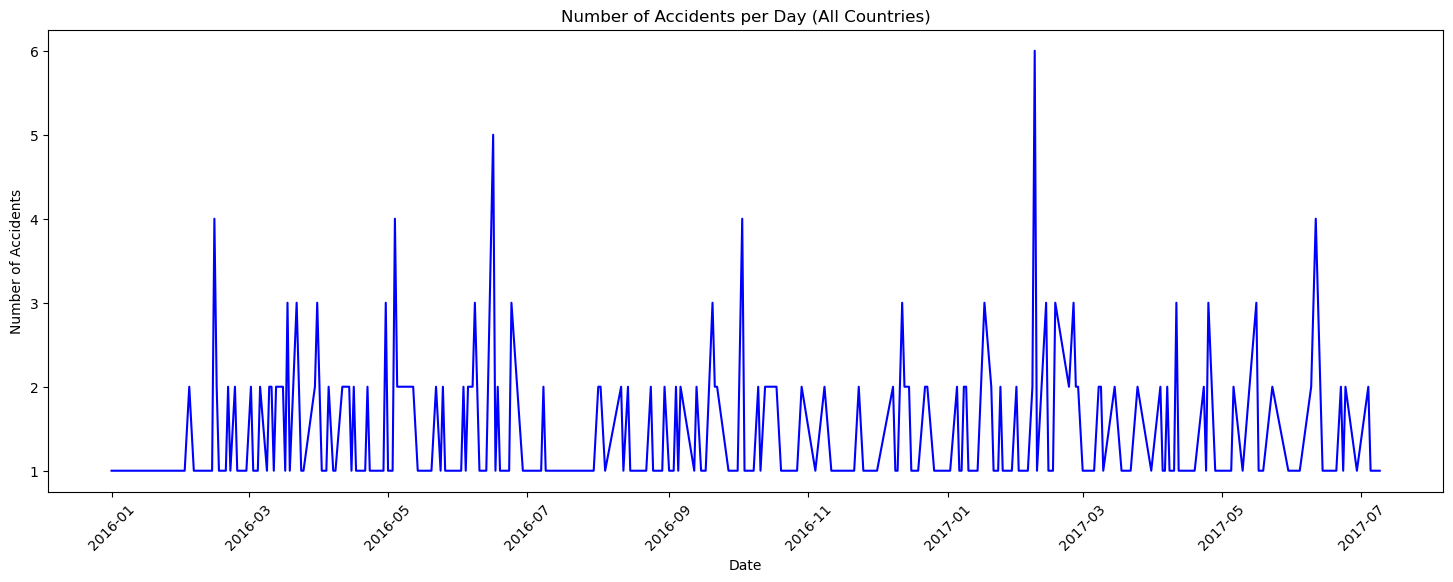

In [66]:
plt.figure(figsize=(18,6))
sns.lineplot(x=daily_accidents.index, y=daily_accidents, color='blue')
plt.title('Number of Accidents per Day (All Countries)')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

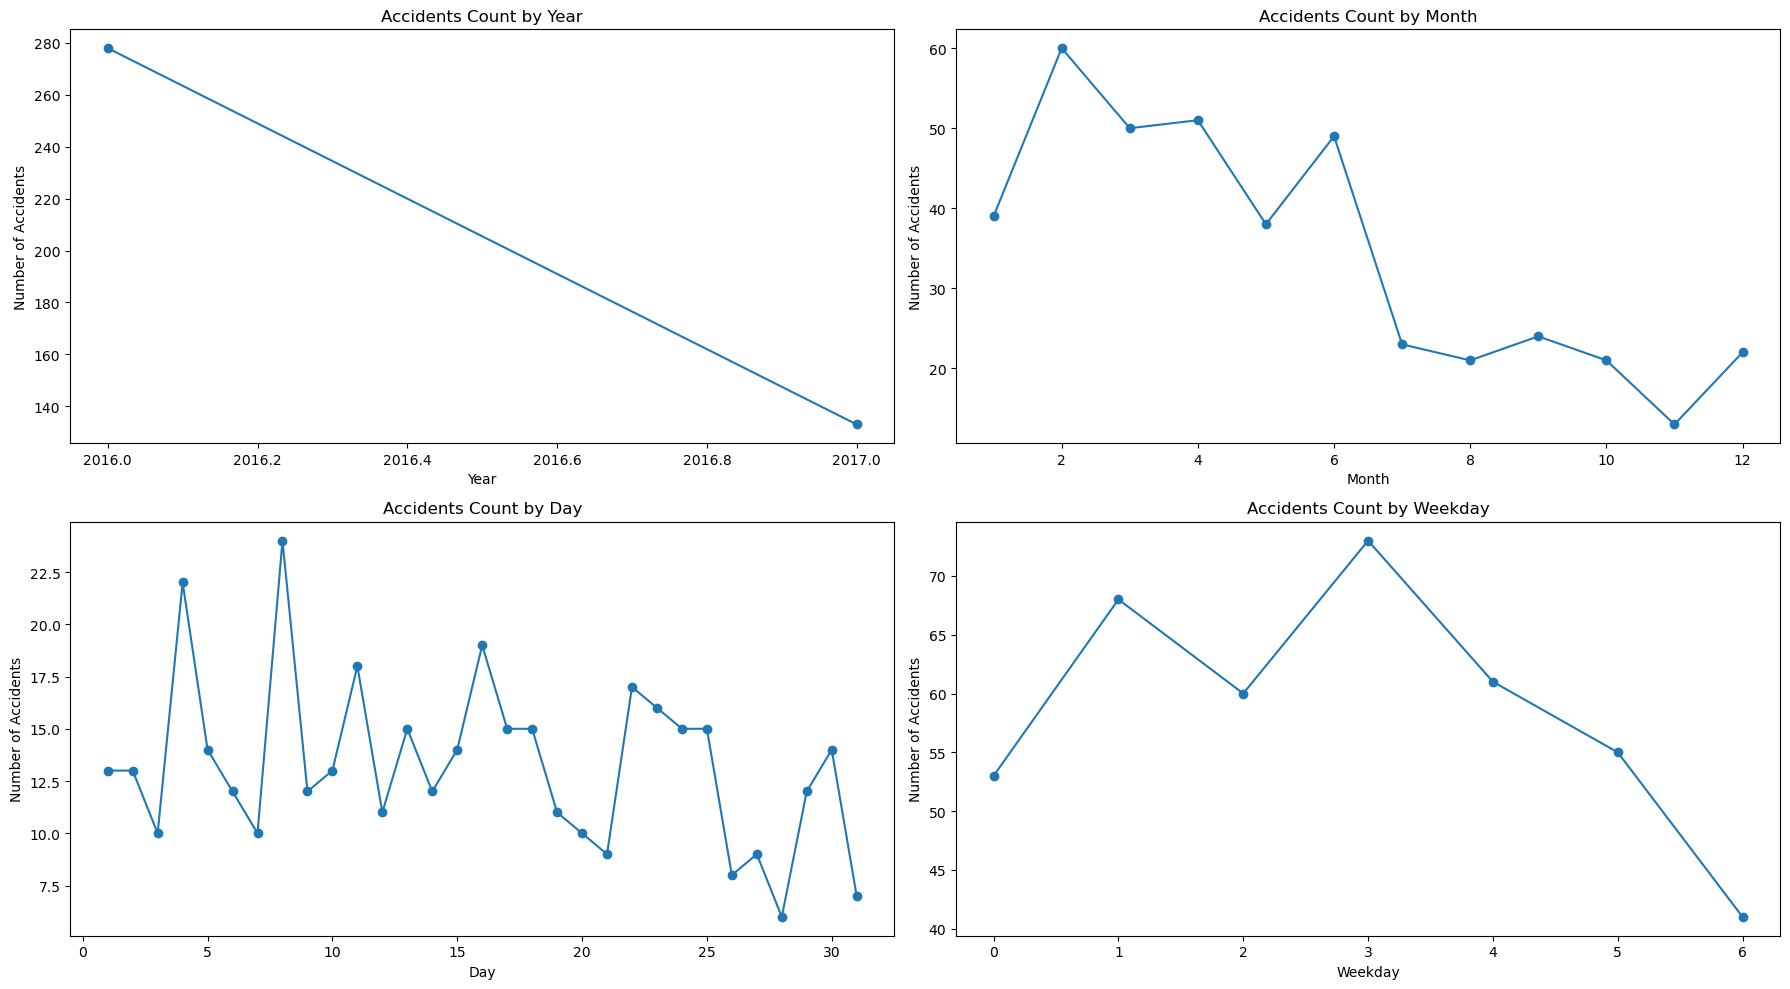

In [67]:
# Plot count of accidents by Year, Month, Day, and Weekday
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Year
data.groupby('Year').size().plot(kind='line', ax=axs[0, 0], marker='o')
axs[0, 0].set_title('Accidents Count by Year')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Number of Accidents')

# Month
data.groupby('Month').size().plot(kind='line', ax=axs[0, 1], marker='o')
axs[0, 1].set_title('Accidents Count by Month')
axs[0, 1].set_xlabel('Month')
axs[0, 1].set_ylabel('Number of Accidents')

# Day
data.groupby('Day').size().plot(kind='line', ax=axs[1, 0], marker='o')
axs[1, 0].set_title('Accidents Count by Day')
axs[1, 0].set_xlabel('Day')
axs[1, 0].set_ylabel('Number of Accidents')

# Weekday
data.groupby('Weekday').size().plot(kind='line', ax=axs[1, 1], marker='o')
axs[1, 1].set_title('Accidents Count by Weekday')
axs[1, 1].set_xlabel('Weekday')
axs[1, 1].set_ylabel('Number of Accidents')

plt.tight_layout()
plt.show()


<Figure size 1300x600 with 0 Axes>

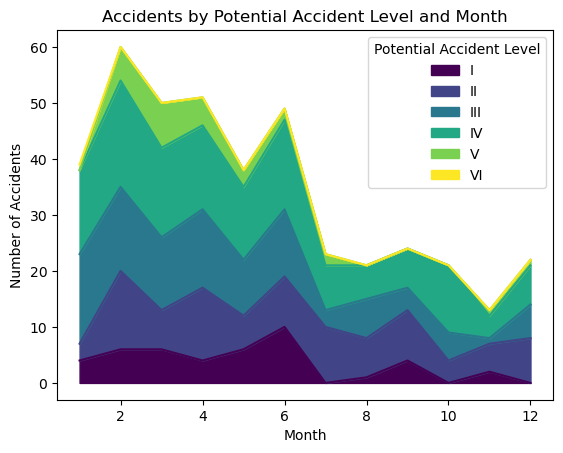

In [68]:
# Pivot table for stacked area plot
area_data = data.pivot_table(index='Month', columns='Potential_Accident_Level', values='Country', aggfunc='count', fill_value=0)

# Plot stacked area plot
plt.figure(figsize=(13, 6))
area_data.plot(kind='area', stacked=True, colormap='viridis')
plt.title('Accidents by Potential Accident Level and Month')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.legend(title='Potential Accident Level')
plt.show()

In [69]:
data = data.reset_index()
data.drop(columns=['Date', 'Day', 'Weekday', 'Year', 'Month'], inplace=True)

In [70]:
data.head()


Country     Local Industry_Sector Accident_Level  \
0  Country_01  Local_01          Mining              I   
1  Country_02  Local_02          Mining              I   
2  Country_01  Local_03          Mining              I   
3  Country_01  Local_04          Mining              I   
4  Country_01  Local_04          Mining             IV   

  Potential_Accident_Level Gender         Employee_Type        Critical_Risk  \
0                       IV   Male           Third Party              Pressed   
1                       IV   Male              Employee  Pressurized Systems   
2                      III   Male  Third Party (Remote)         Manual Tools   
3                        I   Male           Third Party               Others   
4                       IV   Male           Third Party               Others   

                                         Description  
0  While removing the drill rod of the Jumbo 08 f...  
1  During the activation of a sodium sulphide pum...  
2  In the sub-station MILPO located at level +170...  
3  Being 9:45 am. approximately in the Nv. 1880 C...  
4  Approximately at 11:45 a.m. in circumstances t...

In [71]:
# Copy the dataframe 'data'
df2 = data.copy()

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()

cols = list(df2.columns)[:-1]
df2[cols] = encoder.fit_transform(df2[cols])
df2[cols] = df2[cols].astype('int')

df2.head()

Country  Local  Industry_Sector  Accident_Level  Potential_Accident_Level  \
0        0      0                1               0                         3   
1        1      1                1               0                         3   
2        0      2                1               0                         2   
3        0      3                1               0                         0   
4        0      3                1               3                         3   

   Gender  Employee_Type  Critical_Risk  \
0       1              1             20   
1       1              0             21   
2       1              2             15   
3       1              1             16   
4       1              1             16   

                                         Description  
0  While removing the drill rod of the Jumbo 08 f...  
1  During the activation of a sodium sulphide pum...  
2  In the sub-station MILPO located at level +170...  
3  Being 9:45 am. approximately in the Nv. 1880 C...  
4  Approximately at 11:45 a.m. in circumstances t...

In [72]:
des = df2['Description']
des

0      While removing the drill rod of the Jumbo 08 f...
1      During the activation of a sodium sulphide pum...
2      In the sub-station MILPO located at level +170...
3      Being 9:45 am. approximately in the Nv. 1880 C...
4      Approximately at 11:45 a.m. in circumstances t...
                             ...                        
406    Being approximately 5:00 a.m. approximately, w...
407    The collaborator moved from the infrastructure...
408    During the environmental monitoring activity i...
409    The Employee performed the activity of strippi...
410    At 10:00 a.m., when the assistant cleaned the ...
Name: Description, Length: 411, dtype: object

# Text Preprocessing

In [73]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) # Creating a set of English stopwords using the NLTK stopwords corpus

[nltk_data] Downloading package stopwords to C:\Users\Dinesh
[nltk_data]     Chauhan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [74]:
# Import regex library
import re

def clean_text(text):
    text = text.lower() # Convert text to lowercase
    text = re.sub(r'[^\w\s]','',text) # Remove punctuation
    text = re.sub(r'\d+','',text)# Remove digits
    text = re.sub(r'\bpm\b|\bam\b','',text) # Remove 'am' and 'pm'
    words = re.findall(r'\b\w+\b',text) # Extract words
    filtered_words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(filtered_words)  # Join words back into a string

cleaned_description = []
cleaned_description = df2['Description'].apply(clean_text)

In [75]:
cleaned_description

0      removing drill rod jumbo maintenance superviso...
1      activation sodium sulphide pump piping uncoupl...
2      substation milpo located level collaborator ex...
3      approximately nv cx ob personnel begins task u...
4      approximately circumstances mechanics anthony ...
                             ...                        
406    approximately approximately lifting kelly hq t...
407    collaborator moved infrastructure office julio...
408    environmental monitoring activity area employe...
409    employee performed activity stripping cathodes...
410    assistant cleaned floor module e central camp ...
Name: Description, Length: 411, dtype: object

In [76]:
# Add cleaned text to new column 'cleaned_description'
df2['cleaned_description'] = df2['Description'].apply(clean_text)

In [77]:
df2.head(5)

Country  Local  Industry_Sector  Accident_Level  Potential_Accident_Level  \
0        0      0                1               0                         3   
1        1      1                1               0                         3   
2        0      2                1               0                         2   
3        0      3                1               0                         0   
4        0      3                1               3                         3   

   Gender  Employee_Type  Critical_Risk  \
0       1              1             20   
1       1              0             21   
2       1              2             15   
3       1              1             16   
4       1              1             16   

                                         Description  \
0  While removing the drill rod of the Jumbo 08 f...   
1  During the activation of a sodium sulphide pum...   
2  In the sub-station MILPO located at level +170...   
3  Being 9:45 am. approximately in the Nv. 1880 C...   
4  Approximately at 11:45 a.m. in circumstances t...   

                                 cleaned_description  
0  removing drill rod jumbo maintenance superviso...  
1  activation sodium sulphide pump piping uncoupl...  
2  substation milpo located level collaborator ex...  
3  approximately nv cx ob personnel begins task u...  
4  approximately circumstances mechanics anthony ...

In [78]:
df2.drop(columns = 'Description',inplace = True)
df2.head()

Country  Local  Industry_Sector  Accident_Level  Potential_Accident_Level  \
0        0      0                1               0                         3   
1        1      1                1               0                         3   
2        0      2                1               0                         2   
3        0      3                1               0                         0   
4        0      3                1               3                         3   

   Gender  Employee_Type  Critical_Risk  \
0       1              1             20   
1       1              0             21   
2       1              2             15   
3       1              1             16   
4       1              1             16   

                                 cleaned_description  
0  removing drill rod jumbo maintenance superviso...  
1  activation sodium sulphide pump piping uncoupl...  
2  substation milpo located level collaborator ex...  
3  approximately nv cx ob personnel begins task u...  
4  approximately circumstances mechanics anthony ...

In [79]:
import unicodedata
import re

def normalize_text(text):
    # Normalize accented characters to their ASCII equivalent
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode('utf-8')
    # Remove any remaining special characters (optional, based on requirements)
    text = re.sub(r'[¼]', '', text)  # Removing specific special characters like '¼'
    # Optionally, remove any other non-alphanumeric characters if needed
    #text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Apply the normalization function to the 'cleaned_Description' column
df2['cleaned_description'] = df2['cleaned_description'].apply(normalize_text)

# Check the results
print(df2['cleaned_description'].head())

0    removing drill rod jumbo maintenance superviso...
1    activation sodium sulphide pump piping uncoupl...
2    substation milpo located level collaborator ex...
3    approximately nv cx ob personnel begins task u...
4    approximately circumstances mechanics anthony ...
Name: cleaned_description, dtype: object


In [80]:
def non_alpha_ele(text):
    # Extract non-alphabetic characters from text
    return re.findall(r'[^a-zA-Z]', text)

# Apply non_alpha_ele to 'cleaned_description' and store result
cleaned_description_non_alp_ele = df2['cleaned_description'].apply(non_alpha_ele)

cleaned_description_non_alp_ele

0      [ ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ...
1      [ ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ...
2      [ ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ...
3      [ ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ...
4      [ ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ...
                             ...                        
406    [ ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ...
407    [ ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ...
408    [ ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ...
409    [ ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ...
410    [ ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ...
Name: cleaned_description, Length: 411, dtype: object

In [81]:
non_alp = []
for a in cleaned_description_non_alp_ele:
    for k in a:
        non_alp.append(k)
set(non_alp)

{' '}

In [82]:
df2.head()

Country  Local  Industry_Sector  Accident_Level  Potential_Accident_Level  \
0        0      0                1               0                         3   
1        1      1                1               0                         3   
2        0      2                1               0                         2   
3        0      3                1               0                         0   
4        0      3                1               3                         3   

   Gender  Employee_Type  Critical_Risk  \
0       1              1             20   
1       1              0             21   
2       1              2             15   
3       1              1             16   
4       1              1             16   

                                 cleaned_description  
0  removing drill rod jumbo maintenance superviso...  
1  activation sodium sulphide pump piping uncoupl...  
2  substation milpo located level collaborator ex...  
3  approximately nv cx ob personnel begins task u...  
4  approximately circumstances mechanics anthony ...

In [83]:
df2['cleaned_description'] = df2['cleaned_description'].str.strip()
from nltk.stem import PorterStemmer # Import the PorterStemmer class from nltk.stem
ps = PorterStemmer()

In [84]:
# defining a function to perform stemming
def apply_porter_stemmer(text):
    # Split text into separate words
    words = text.split()

    # Applying the Porter Stemmer on every word of a message and joining the stemmed words back into a single string
    new_text = ' '.join([ps.stem(word) for word in words])

    return new_text


In [85]:
# Applying the function to perform stemming
df2['cleaned_description'] = df2['cleaned_description'].apply(apply_porter_stemmer)

In [86]:
df2.head()

Country  Local  Industry_Sector  Accident_Level  Potential_Accident_Level  \
0        0      0                1               0                         3   
1        1      1                1               0                         3   
2        0      2                1               0                         2   
3        0      3                1               0                         0   
4        0      3                1               3                         3   

   Gender  Employee_Type  Critical_Risk  \
0       1              1             20   
1       1              0             21   
2       1              2             15   
3       1              1             16   
4       1              1             16   

                                 cleaned_description  
0  remov drill rod jumbo mainten supervisor proce...  
1  activ sodium sulphid pump pipe uncoupl sulfid ...  
2  substat milpo locat level collabor excav work ...  
3  approxim nv cx ob personnel begin task unlock ...  
4  approxim circumst mechan anthoni group leader ...

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the 'cleaned_Description' column
tfidf_matrix = tfidf_vectorizer.fit_transform(df2['cleaned_description'])

# Convert the result to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the resulting DataFrame
tfidf_df


abb  abdomen  abl  abratech  abrupt  abruptli  absorb  abut  acc  \
0    0.0      0.0  0.0       0.0     0.0       0.0     0.0   0.0  0.0   
1    0.0      0.0  0.0       0.0     0.0       0.0     0.0   0.0  0.0   
2    0.0      0.0  0.0       0.0     0.0       0.0     0.0   0.0  0.0   
3    0.0      0.0  0.0       0.0     0.0       0.0     0.0   0.0  0.0   
4    0.0      0.0  0.0       0.0     0.0       0.0     0.0   0.0  0.0   
..   ...      ...  ...       ...     ...       ...     ...   ...  ...   
406  0.0      0.0  0.0       0.0     0.0       0.0     0.0   0.0  0.0   
407  0.0      0.0  0.0       0.0     0.0       0.0     0.0   0.0  0.0   
408  0.0      0.0  0.0       0.0     0.0       0.0     0.0   0.0  0.0   
409  0.0      0.0  0.0       0.0     0.0       0.0     0.0   0.0  0.0   
410  0.0      0.0  0.0       0.0     0.0       0.0     0.0   0.0  0.0   

      acceler  ...  yield  yolk  young       zaf  zamac  zero  zinc  zinco  \
0    0.197518  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   
1    0.000000  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   
2    0.000000  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   
3    0.000000  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   
4    0.000000  ...    0.0   0.0    0.0  0.207487    0.0   0.0   0.0    0.0   
..        ...  ...    ...   ...    ...       ...    ...   ...   ...    ...   
406  0.000000  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   
407  0.000000  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   
408  0.000000  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   
409  0.000000  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   
410  0.000000  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   

      zn  zone  
0    0.0   0.0  
1    0.0   0.0  
2    0.0   0.0  
3    0.0   0.0  
4    0.0   0.0  
..   ...   ...  
406  0.0   0.0  
407  0.0   0.0  
408  0.0   0.0  
409  0.0   0.0  
410  0.0   0.0  

[411 rows x 2267 columns]

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

# Vectorize the 'cleaned_description' column using TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the 'cleaned_description' column
tfidf_matrix = tfidf_vectorizer.fit_transform(df2['cleaned_description'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Drop the original 'cleaned_description' column
df2_cleaned_tf = df2.drop(columns=['cleaned_description'])

# Combine TF-IDF DataFrame with the rest of df2
df2_combined_tf = pd.concat([df2_cleaned_tf.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

In [89]:
df2_combined_tf

Country  Local  Industry_Sector  Accident_Level  \
0          0      0                1               0   
1          1      1                1               0   
2          0      2                1               0   
3          0      3                1               0   
4          0      3                1               3   
..       ...    ...              ...             ...   
406        0      3                1               0   
407        0      2                1               0   
408        1      8                0               0   
409        1      4                0               0   
410        0      3                1               0   

     Potential_Accident_Level  Gender  Employee_Type  Critical_Risk  abb  \
0                           3       1              1             20  0.0   
1                           3       1              0             21  0.0   
2                           2       1              2             15  0.0   
3                           0       1              1             16  0.0   
4                           3       1              1             16  0.0   
..                        ...     ...            ...            ...  ...   
406                         2       1              1             16  0.0   
407                         1       0              0             16  0.0   
408                         1       1              0             31  0.0   
409                         1       1              0              6  0.0   
410                         1       0              1             11  0.0   

     abdomen  ...  yield  yolk  young       zaf  zamac  zero  zinc  zinco  \
0        0.0  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   
1        0.0  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   
2        0.0  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   
3        0.0  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   
4        0.0  ...    0.0   0.0    0.0  0.207487    0.0   0.0   0.0    0.0   
..       ...  ...    ...   ...    ...       ...    ...   ...   ...    ...   
406      0.0  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   
407      0.0  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   
408      0.0  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   
409      0.0  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   
410      0.0  ...    0.0   0.0    0.0  0.000000    0.0   0.0   0.0    0.0   

      zn  zone  
0    0.0   0.0  
1    0.0   0.0  
2    0.0   0.0  
3    0.0   0.0  
4    0.0   0.0  
..   ...   ...  
406  0.0   0.0  
407  0.0   0.0  
408  0.0   0.0  
409  0.0   0.0  
410  0.0   0.0  

[411 rows x 2275 columns]

In [90]:
# Define X and y
X = df2_combined_tf.drop(columns=['Potential_Accident_Level'])
y = df2_combined_tf['Potential_Accident_Level']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [92]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.4819277108433735
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.64      0.43      0.51        21
           2       0.43      0.27      0.33        22
           3       0.43      0.81      0.56        27
           4       0.00      0.00      0.00         9

    accuracy                           0.48        83
   macro avg       0.45      0.45      0.43        83
weighted avg       0.45      0.48      0.44        83



C:\Users\Dinesh Chauhan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dinesh Chauhan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dinesh Chauhan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# List of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict on the test set
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    report = classification_report(y_test, y_pred, output_dict=True)  # Get classification report
    results[model_name] = {"Accuracy": accuracy, "Report": report}
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print("-" * 60)


Model: Logistic Regression
Accuracy: 0.5180722891566265
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.59      0.48      0.53        21
           2       0.38      0.36      0.37        22
           3       0.49      0.70      0.58        27
           4       1.00      0.22      0.36         9

    accuracy                           0.52        83
   macro avg       0.69      0.55      0.57        83
weighted avg       0.56      0.52      0.51        83

------------------------------------------------------------
Model: Random Forest
Accuracy: 0.4819277108433735
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.64      0.43      0.51        21
           2       0.43      0.27      0.33        22
           3       0.43      0.81      0.56        27
           4       0.00    

RandomSearch CV with out Smote

In [94]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define parameter grid for Logistic Regression
param_dist_lr = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'saga']
}

# Initialize the model
lr = LogisticRegression()

# Initialize RandomizedSearchCV
random_search_lr = RandomizedSearchCV(estimator=lr, param_distributions=param_dist_lr,
                                      cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV
random_search_lr.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best Parameters for Logistic Regression: {random_search_lr.best_params_}")
print(f"Best Accuracy for Logistic Regression (Training Cross-Validation): {random_search_lr.best_score_}")

# Train the model with the best parameters
tf_best_lr = random_search_lr.best_estimator_
tf_best_lr.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred_lr = tf_best_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)

print(f"Optimized Logistic Regression Accuracy (Test Set): {accuracy_lr}")
print(f"Optimized Logistic Regression Classification Report:\n{report_lr}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Logistic Regression: {'solver': 'lbfgs', 'C': 1}
Best Accuracy for Logistic Regression (Training Cross-Validation): 0.5030769230769231
Optimized Logistic Regression Accuracy (Test Set): 0.5180722891566265
Optimized Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.59      0.48      0.53        21
           2       0.38      0.36      0.37        22
           3       0.49      0.70      0.58        27
           4       1.00      0.22      0.36         9

    accuracy                           0.52        83
   macro avg       0.69      0.55      0.57        83
weighted avg       0.56      0.52      0.51        83



In [95]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for RandomForestClassifier
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_rf,
                                      cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV
random_search_rf.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_rf = random_search_rf.best_params_
tf_best_rf = random_search_rf.best_estimator_

# Predict on the test set
y_pred_rf = tf_best_rf.predict(X_test)

# Evaluate the tuned model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print(f"Best Parameters for RandomForestClassifier: {best_params_rf}")
print(f"Accuracy after tuning: {accuracy_rf}")
print(f"Classification Report after tuning:\n{report_rf}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for RandomForestClassifier: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': False}
Accuracy after tuning: 0.4819277108433735
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.64      0.43      0.51        21
           2       0.46      0.27      0.34        22
           3       0.42      0.81      0.56        27
           4       0.00      0.00      0.00         9

    accuracy                           0.48        83
   macro avg       0.46      0.45      0.43        83
weighted avg       0.46      0.48      0.44        83

------------------------------------------------------------


In [96]:
#desicion tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for DecisionTreeClassifier
param_dist_dt = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

# Initialize the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_dt = RandomizedSearchCV(estimator=dt, param_distributions=param_dist_dt,
                                      cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV
random_search_dt.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_dt = random_search_dt.best_params_
tf_best_dt = random_search_dt.best_estimator_

# Predict on the test set
y_pred_dt = tf_best_dt.predict(X_test)

# Evaluate the tuned model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)

print(f"Best Parameters for DecisionTreeClassifier: {best_params_dt}")
print(f"Accuracy after tuning: {accuracy_dt}")
print(f"Classification Report after tuning:\n{report_dt}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for DecisionTreeClassifier: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'entropy'}
Accuracy after tuning: 0.46987951807228917
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.43      0.75      0.55         4
           1       0.55      0.29      0.37        21
           2       0.40      0.77      0.53        22
           3       0.53      0.33      0.41        27
           4       0.67      0.44      0.53         9

    accuracy                           0.47        83
   macro avg       0.51      0.52      0.48        83
weighted avg       0.51      0.47      0.45        83

------------------------------------------------------------


In [97]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for SVC
param_dist_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Initialize the SVC
svc = SVC(random_state=42)

# Initialize RandomizedSearchCV
random_search_svc = RandomizedSearchCV(estimator=svc, param_distributions=param_dist_svc,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV
random_search_svc.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_svc = random_search_svc.best_params_
tf_best_svc = random_search_svc.best_estimator_

# Predict on the test set
y_pred_svc = tf_best_svc.predict(X_test)

# Evaluate the tuned model
accuracy_svc = accuracy_score(y_test, y_pred_svc)
report_svc = classification_report(y_test, y_pred_svc)

print(f"Best Parameters for SVC: {best_params_svc}")
print(f"Accuracy after tuning: {accuracy_svc}")
print(f"Classification Report after tuning:\n{report_svc}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for SVC: {'kernel': 'linear', 'gamma': 0.1, 'C': 100}
Accuracy after tuning: 0.46987951807228917
Classification Report after tuning:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.50      0.52      0.51        21
           2       0.53      0.41      0.46        22
           3       0.38      0.56      0.45        27
           4       0.00      0.00      0.00         9

    accuracy                           0.47        83
   macro avg       0.48      0.50      0.49        83
weighted avg       0.44      0.47      0.45        83

------------------------------------------------------------


In [98]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for KNeighborsClassifier
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize the KNeighborsClassifier
knn = KNeighborsClassifier()

# Initialize RandomizedSearchCV
random_search_knn = RandomizedSearchCV(estimator=knn, param_distributions=param_dist_knn,
                                        cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the data
random_search_knn.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_knn = random_search_knn.best_params_
tf_best_knn = random_search_knn.best_estimator_

# Predict on the test set
y_pred_knn = tf_best_knn.predict(X_test)

# Evaluate the tuned model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)

print(f"Best Parameters for K-Nearest Neighbors: {best_params_knn}")
print(f"Accuracy after tuning: {accuracy_knn}")
print(f"Classification Report after tuning:\n{report_knn}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for K-Nearest Neighbors: {'weights': 'distance', 'n_neighbors': 11, 'metric': 'euclidean'}
Accuracy after tuning: 0.4578313253012048
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.50      0.48      0.49        21
           2       0.40      0.45      0.43        22
           3       0.48      0.56      0.52        27
           4       0.00      0.00      0.00         9

    accuracy                           0.46        83
   macro avg       0.40      0.45      0.42        83
weighted avg       0.42      0.46      0.44        83

------------------------------------------------------------


In [99]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for GradientBoostingClassifier
param_dist_gbc = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'criterion': ['friedman_mse', 'mse', 'mae']
}

# Initialize the GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_gbc = RandomizedSearchCV(estimator=gbc, param_distributions=param_dist_gbc,
                                        cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the data
random_search_gbc.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_gbc = random_search_gbc.best_params_
tf_best_gbc = random_search_gbc.best_estimator_

# Predict on the test set
y_pred_gbc = tf_best_gbc.predict(X_test)

# Evaluate the tuned model
accuracy_gbc = accuracy_score(y_test, y_pred_gbc)
report_gbc = classification_report(y_test, y_pred_gbc)

print(f"Best Parameters for Gradient Boosting: {best_params_gbc}")
print(f"Accuracy after tuning: {accuracy_gbc}")
print(f"Classification Report after tuning:\n{report_gbc}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Gradient Boosting: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'criterion': 'friedman_mse'}
Accuracy after tuning: 0.5180722891566265
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.43      0.43      0.43        21
           2       0.47      0.41      0.44        22
           3       0.53      0.70      0.60        27
           4       1.00      0.33      0.50         9

    accuracy                           0.52        83
   macro avg       0.64      0.52      0.54        83
weighted avg       0.55      0.52      0.51        83

------------------------------------------------------------


In [100]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for AdaBoostClassifier
param_dist_ada = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 1.0, 10.0]
}

# Initialize the AdaBoostClassifier
ada = AdaBoostClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_ada = RandomizedSearchCV(estimator=ada, param_distributions=param_dist_ada,
                                        cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the data
random_search_ada.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_ada = random_search_ada.best_params_
tf_best_ada = random_search_ada.best_estimator_

# Predict on the test set
y_pred_ada = tf_best_ada.predict(X_test)

# Evaluate the tuned model
accuracy_ada = accuracy_score(y_test, y_pred_ada)
report_ada = classification_report(y_test, y_pred_ada)

print(f"Best Parameters for AdaBoost: {best_params_ada}")
print(f"Accuracy after tuning: {accuracy_ada}")
print(f"Classification Report after tuning:\n{report_ada}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for AdaBoost: {'n_estimators': 100, 'learning_rate': 0.01}
Accuracy after tuning: 0.3855421686746988
Classification Report after tuning:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.00      0.00      0.00        21
           2       0.33      0.86      0.48        22
           3       0.50      0.44      0.47        27
           4       0.00      0.00      0.00         9

    accuracy                           0.39        83
   macro avg       0.37      0.31      0.27        83
weighted avg       0.30      0.39      0.30        83

------------------------------------------------------------


In [101]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for XGBClassifier
param_dist_xgb = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the XGBClassifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist_xgb,
                                        cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the data
random_search_xgb.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_xgb = random_search_xgb.best_params_
tf_best_xgb = random_search_xgb.best_estimator_

# Predict on the test set
y_pred_xgb = tf_best_xgb.predict(X_test)

# Evaluate the tuned model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

print(f"Best Parameters for XGBoost: {best_params_xgb}")
print(f"Accuracy after tuning: {accuracy_xgb}")
print(f"Classification Report after tuning:\n{report_xgb}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Accuracy after tuning: 0.4819277108433735
Classification Report after tuning:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.45      0.48      0.47        21
           2       0.44      0.36      0.40        22
           3       0.47      0.67      0.55        27
           4       0.50      0.11      0.18         9

    accuracy                           0.48        83
   macro avg       0.57      0.47      0.49        83
weighted avg       0.49      0.48      0.46        83

------------------------------------------------------------


In [102]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for LGBMClassifier
param_dist_lgbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 10, 20],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_lgbm = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist_lgbm,
                                         cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the training data
random_search_lgbm.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_lgbm = random_search_lgbm.best_params_
tf_best_lgbm = random_search_lgbm.best_estimator_

# Predict on the test set
y_pred_lgbm = tf_best_lgbm.predict(X_test)

# Evaluate the tuned model
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
report_lgbm = classification_report(y_test, y_pred_lgbm)

print(f"Best Parameters for LGBMClassifier: {best_params_lgbm}")
print(f"Accuracy after tuning: {accuracy_lgbm}")
print(f"Classification Report after tuning:\n{report_lgbm}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1309
[LightGBM] [Info] Number of data points in the train set: 328, number of used features: 89
[LightGBM] [Info] Start training from score -2.129452
[LightGBM] [Info] Start training from score -1.488949
[LightGBM] [Info] Start training from score -1.362197
[LightGBM] [Info] Start training from score -1.083483
[LightGBM] [Info] Start training from score -2.848575
[LightGBM] [Info] Start training from score -5.793014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [103]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for ExtraTreesClassifier
param_dist_et = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the ExtraTreesClassifier
et = ExtraTreesClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_et = RandomizedSearchCV(estimator=et, param_distributions=param_dist_et,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the training data
random_search_et.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_et = random_search_et.best_params_
tf_best_et = random_search_et.best_estimator_

# Predict on the test set
y_pred_et = tf_best_et.predict(X_test)

# Evaluate the tuned model
accuracy_et = accuracy_score(y_test, y_pred_et)
report_et = classification_report(y_test, y_pred_et)

print(f"Best Parameters for ExtraTreesClassifier: {best_params_et}")
print(f"Accuracy after tuning: {accuracy_et}")
print(f"Classification Report after tuning:\n{report_et}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for ExtraTreesClassifier: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}
Accuracy after tuning: 0.4578313253012048
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.50      0.57      0.53        21
           2       0.30      0.14      0.19        22
           3       0.46      0.78      0.58        27
           4       0.00      0.00      0.00         9

    accuracy                           0.46        83
   macro avg       0.38      0.40      0.37        83
weighted avg       0.39      0.46      0.40        83

------------------------------------------------------------


## Using SMOTE(BorderlineSMOTE)

In [104]:
from imblearn.over_sampling import BorderlineSMOTE

# Initialize BorderlineSMOTE
borderline_smote = BorderlineSMOTE(random_state=42)

# Fit and resample the training data
X_resampled, y_resampled = borderline_smote.fit_resample(X_train, y_train)


In [105]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# List of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for model_name, model in models.items():
    model.fit(X_resampled, y_resampled)  # Train the model
    y_pred = model.predict(X_test)  # Predict on the test set
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    report = classification_report(y_test, y_pred, output_dict=True)  # Get classification report
    results[model_name] = {"Accuracy": accuracy, "Report": report}
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print("-" * 60)

Model: Logistic Regression
Accuracy: 0.5301204819277109
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.60      0.57      0.59        21
           2       0.42      0.45      0.43        22
           3       0.50      0.52      0.51        27
           4       0.57      0.44      0.50         9

    accuracy                           0.53        83
   macro avg       0.62      0.60      0.61        83
weighted avg       0.54      0.53      0.53        83

------------------------------------------------------------
Model: Random Forest
Accuracy: 0.5180722891566265
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.65      0.62      0.63        21
           2       0.47      0.41      0.44        22
           3       0.47      0.67      0.55        27
           4       0.00    

In [106]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for LogisticRegression
param_dist_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l2'],  # 'l1' penalty can only be used with certain solvers
    'max_iter': [100, 200, 300]
}

# Initialize the LogisticRegression
lr = LogisticRegression(random_state=42)

# Initialize RandomizedSearchCV
random_search_lr = RandomizedSearchCV(estimator=lr, param_distributions=param_dist_lr,
                                      cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_lr.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_lr = random_search_lr.best_params_
tf_smote_best_lr = random_search_lr.best_estimator_

# Predict on the test set
y_pred_lr = tf_smote_best_lr.predict(X_test)

# Evaluate the tuned model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)

print(f"Best Parameters for LogisticRegression: {best_params_lr}")
print(f"Accuracy after tuning: {accuracy_lr}")
print(f"Classification Report after tuning:\n{report_lr}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for LogisticRegression: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 200, 'C': 1}
Accuracy after tuning: 0.5060240963855421
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.55      0.57      0.56        21
           2       0.38      0.45      0.42        22
           3       0.52      0.44      0.48        27
           4       0.57      0.44      0.50         9

    accuracy                           0.51        83
   macro avg       0.56      0.58      0.57        83
weighted avg       0.51      0.51      0.50        83

------------------------------------------------------------


In [107]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for SVC
param_dist_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Initialize the SVC
svc = SVC(random_state=42)

# Initialize RandomizedSearchCV
random_search_svc = RandomizedSearchCV(estimator=svc, param_distributions=param_dist_svc,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_svc.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_svc = random_search_svc.best_params_
tf_smote_best_svc = random_search_svc.best_estimator_

# Predict on the test set
y_pred_svc = tf_smote_best_svc.predict(X_test)

# Evaluate the tuned model
accuracy_svc = accuracy_score(y_test, y_pred_svc)
report_svc = classification_report(y_test, y_pred_svc)

print(f"Best Parameters for SVC: {best_params_svc}")
print(f"Accuracy after tuning: {accuracy_svc}")
print(f"Classification Report after tuning:\n{report_svc}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for SVC: {'kernel': 'linear', 'gamma': 0.1, 'C': 100}
Accuracy after tuning: 0.4819277108433735
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.52      0.52      0.52        21
           2       0.53      0.45      0.49        22
           3       0.41      0.56      0.47        27
           4       0.00      0.00      0.00         9

    accuracy                           0.48        83
   macro avg       0.45      0.51      0.47        83
weighted avg       0.44      0.48      0.46        83

------------------------------------------------------------


In [108]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for RandomForestClassifier
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_rf,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_rf.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_rf = random_search_rf.best_params_
tf_smote_best_rf = random_search_rf.best_estimator_

# Predict on the test set
y_pred_rf = tf_smote_best_rf.predict(X_test)

# Evaluate the tuned model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print(f"Best Parameters for RandomForestClassifier: {best_params_rf}")
print(f"Accuracy after tuning: {accuracy_rf}")
print(f"Classification Report after tuning:\n{report_rf}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for RandomForestClassifier: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}
Accuracy after tuning: 0.5180722891566265
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.40      0.50      0.44         4
           1       0.60      0.57      0.59        21
           2       0.58      0.50      0.54        22
           3       0.46      0.67      0.55        27
           4       0.00      0.00      0.00         9

    accuracy                           0.52        83
   macro avg       0.41      0.45      0.42        83
weighted avg       0.47      0.52      0.49        83

------------------------------------------------------------


In [109]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for DecisionTreeClassifier
param_dist_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_dt = RandomizedSearchCV(estimator=dt, param_distributions=param_dist_dt,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_dt.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_dt = random_search_dt.best_params_
tf_smote_best_dt = random_search_dt.best_estimator_

# Predict on the test set
y_pred_dt = tf_smote_best_dt.predict(X_test)

# Evaluate the tuned model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)

print(f"Best Parameters for DecisionTreeClassifier: {best_params_dt}")
print(f"Accuracy after tuning: {accuracy_dt}")
print(f"Classification Report after tuning:\n{report_dt}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for DecisionTreeClassifier: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 40, 'criterion': 'gini'}
Accuracy after tuning: 0.46987951807228917
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.46      0.62      0.53        21
           2       0.43      0.27      0.33        22
           3       0.47      0.59      0.52        27
           4       0.50      0.11      0.18         9

    accuracy                           0.47        83
   macro avg       0.49      0.47      0.45        83
weighted avg       0.47      0.47      0.45        83

------------------------------------------------------------


In [110]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for KNeighborsClassifier
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize the KNeighborsClassifier
knn = KNeighborsClassifier()

# Initialize RandomizedSearchCV
random_search_knn = RandomizedSearchCV(estimator=knn, param_distributions=param_dist_knn,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_knn.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_knn = random_search_knn.best_params_
tf_smote_best_knn = random_search_knn.best_estimator_

# Predict on the test set
y_pred_knn = tf_smote_best_knn.predict(X_test)

# Evaluate the tuned model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)

print(f"Best Parameters for K-Nearest Neighbors: {best_params_knn}")
print(f"Accuracy after tuning: {accuracy_knn}")
print(f"Classification Report after tuning:\n{report_knn}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for K-Nearest Neighbors: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'manhattan'}
Accuracy after tuning: 0.37349397590361444
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.29      1.00      0.44         4
           1       0.38      0.57      0.45        21
           2       0.44      0.32      0.37        22
           3       0.38      0.22      0.28        27
           4       0.40      0.22      0.29         9

    accuracy                           0.37        83
   macro avg       0.37      0.47      0.37        83
weighted avg       0.39      0.37      0.36        83

------------------------------------------------------------


In [111]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for GradientBoostingClassifier
param_dist_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'max_depth': [3, 4, 5, 6]
}

# Initialize the GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_gb = RandomizedSearchCV(estimator=gb, param_distributions=param_dist_gb,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_gb.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_gb = random_search_gb.best_params_
tf_smote_best_gb = random_search_gb.best_estimator_

# Predict on the test set
y_pred_gb = tf_smote_best_gb.predict(X_test)

# Evaluate the tuned model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
report_gb = classification_report(y_test, y_pred_gb)

print(f"Best Parameters for Gradient Boosting: {best_params_gb}")
print(f"Accuracy after tuning: {accuracy_gb}")
print(f"Classification Report after tuning:\n{report_gb}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Gradient Boosting: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 1}
Accuracy after tuning: 0.4457831325301205
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.38      0.75      0.50         4
           1       0.48      0.48      0.48        21
           2       0.42      0.50      0.46        22
           3       0.48      0.48      0.48        27
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00         0

    accuracy                           0.45        83
   macro avg       0.29      0.37      0.32        83
weighted avg       0.41      0.45      0.42        83

------------------------------------------------------------


In [112]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for AdaBoostClassifier
param_dist_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 1]
}

# Initialize the AdaBoostClassifier
ab = AdaBoostClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_ab = RandomizedSearchCV(estimator=ab, param_distributions=param_dist_ab,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_ab.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_ab = random_search_ab.best_params_
tf_smote_best_ab = random_search_ab.best_estimator_

# Predict on the test set
y_pred_ab = tf_smote_best_ab.predict(X_test)

# Evaluate the tuned model
accuracy_ab = accuracy_score(y_test, y_pred_ab)
report_ab = classification_report(y_test, y_pred_ab)

print(f"Best Parameters for AdaBoost: {best_params_ab}")
print(f"Accuracy after tuning: {accuracy_ab}")
print(f"Classification Report after tuning:\n{report_ab}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for AdaBoost: {'n_estimators': 200, 'learning_rate': 1}
Accuracy after tuning: 0.43373493975903615
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.53      0.38      0.44        21
           2       0.31      0.41      0.35        22
           3       0.48      0.59      0.53        27
           4       0.50      0.11      0.18         9

    accuracy                           0.43        83
   macro avg       0.47      0.40      0.40        83
weighted avg       0.45      0.43      0.42        83

------------------------------------------------------------


In [113]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for XGBoost
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the XGBoostClassifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist_xgb,
                                        cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_xgb.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_xgb = random_search_xgb.best_params_
tf_smote_best_xgb = random_search_xgb.best_estimator_

# Predict on the test set
y_pred_xgb = tf_smote_best_xgb.predict(X_test)

# Evaluate the tuned model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

print(f"Best Parameters for XGBoost: {best_params_xgb}")
print(f"Accuracy after tuning: {accuracy_xgb}")
print(f"Classification Report after tuning:\n{report_xgb}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Accuracy after tuning: 0.4939759036144578
Classification Report after tuning:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.45      0.43      0.44        21
           2       0.39      0.41      0.40        22
           3       0.54      0.74      0.62        27
           4       0.00      0.00      0.00         9

    accuracy                           0.49        83
   macro avg       0.48      0.47      0.46        83
weighted avg       0.44      0.49      0.46        83

------------------------------------------------------------


In [114]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for LightGBM
param_dist_lgbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [-1, 10, 20, 30],
    'num_leaves': [31, 63, 127],
    'boosting_type': ['gbdt', 'dart']
}

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_lgbm = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist_lgbm,
                                         cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_lgbm.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_lgbm = random_search_lgbm.best_params_
tf_smote_best_lgbm = random_search_lgbm.best_estimator_

# Predict on the test set
y_pred_lgbm = tf_smote_best_lgbm.predict(X_test)

# Evaluate the tuned model
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
report_lgbm = classification_report(y_test, y_pred_lgbm)

print(f"Best Parameters for LightGBM: {best_params_lgbm}")
print(f"Accuracy after tuning: {accuracy_lgbm}")
print(f"Classification Report after tuning:\n{report_lgbm}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5405
[LightGBM] [Info] Number of data points in the train set: 556, number of used features: 312
[LightGBM] [Info] Start training from score -1.611238
[LightGBM] [Info] Start training from score -1.611238
[LightGBM] [Info] Start training from score -1.611238
[LightGBM] [Info] Start training from score -1.611238
[LightGBM] [Info] Start training from score -1.611238
[LightGBM] [Info] Start training from score -6.320768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [115]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for ExtraTreesClassifier
param_dist_et = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the ExtraTreesClassifier
et = ExtraTreesClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_et = RandomizedSearchCV(estimator=et, param_distributions=param_dist_et,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_et.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_et = random_search_et.best_params_
tf_smote_best_et = random_search_et.best_estimator_

# Predict on the test set
y_pred_et = tf_smote_best_et.predict(X_test)

# Evaluate the tuned model
accuracy_et = accuracy_score(y_test, y_pred_et)
report_et = classification_report(y_test, y_pred_et)

print(f"Best Parameters for Extra Trees: {best_params_et}")
print(f"Accuracy after tuning: {accuracy_et}")
print(f"Classification Report after tuning:\n{report_et}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Extra Trees: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Accuracy after tuning: 0.5060240963855421
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.59      0.48      0.53        21
           2       0.60      0.41      0.49        22
           3       0.44      0.74      0.56        27
           4       0.00      0.00      0.00         9

    accuracy                           0.51        83
   macro avg       0.43      0.48      0.43        83
weighted avg       0.48      0.51      0.47        83

------------------------------------------------------------


## GloVe

In [116]:
from gensim.scripts.glove2word2vec import glove2word2vec

In [117]:
glove_input_file = 'glove.6B.50d.txt'
word2vec_output_file = 'glove.6B.50d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 50)

In [118]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.50d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [119]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((50,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_model[word])

    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)


    return feature_vector

In [120]:
glove_words = glove_model.index_to_key

In [121]:
df3 = df2.copy()
df3 = df3.reset_index()
df3.drop(columns=['index'],inplace=True)
df3

Country  Local  Industry_Sector  Accident_Level  \
0          0      0                1               0   
1          1      1                1               0   
2          0      2                1               0   
3          0      3                1               0   
4          0      3                1               3   
..       ...    ...              ...             ...   
406        0      3                1               0   
407        0      2                1               0   
408        1      8                0               0   
409        1      4                0               0   
410        0      3                1               0   

     Potential_Accident_Level  Gender  Employee_Type  Critical_Risk  \
0                           3       1              1             20   
1                           3       1              0             21   
2                           2       1              2             15   
3                           0       1              1             16   
4                           3       1              1             16   
..                        ...     ...            ...            ...   
406                         2       1              1             16   
407                         1       0              0             16   
408                         1       1              0             31   
409                         1       1              0              6   
410                         1       0              1             11   

                                   cleaned_description  
0    remov drill rod jumbo mainten supervisor proce...  
1    activ sodium sulphid pump pipe uncoupl sulfid ...  
2    substat milpo locat level collabor excav work ...  
3    approxim nv cx ob personnel begin task unlock ...  
4    approxim circumst mechan anthoni group leader ...  
..                                                 ...  
406  approxim approxim lift kelli hq toward pulley ...  
407  collabor move infrastructur offic julio toilet...  
408  environment monitor activ area employe surpris...  
409  employe perform activ strip cathod pull cathod...  
410  assist clean floor modul e central camp slip b...  

[411 rows x 9 columns]

In [122]:
df4 = pd.DataFrame(df3['cleaned_description'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(50)])
df4

Feature 0  Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  \
0    -0.077208  -0.017825   0.217730  -0.138790   0.082557  -0.012006   
1     0.271806   0.274290   0.320448  -0.206786   0.053210   0.363607   
2     0.054804  -0.105934   0.211705  -0.163198   0.265520   0.088124   
3     0.164808  -0.093788   0.281989   0.042357   0.196371   0.096150   
4    -0.077230   0.133346   0.468211  -0.139532   0.158050   0.321304   
..         ...        ...        ...        ...        ...        ...   
406  -0.019988  -0.152403   0.372265  -0.147685   0.451526   0.208577   
407   0.015563  -0.106882   0.122386  -0.107212   0.170532  -0.172028   
408   0.425928  -0.063157   0.123614   0.008376   0.058975   0.026745   
409   0.074327  -0.139056   0.263140  -0.273395   0.116468   0.168534   
410   0.166996  -0.054175   0.337276  -0.252623   0.144839  -0.259541   

     Feature 6  Feature 7  Feature 8  Feature 9  ...  Feature 40  Feature 41  \
0    -0.059623   0.043636   0.024376  -0.250302  ...   -0.098531    0.174895   
1     0.094786  -0.175129   0.162497   0.321926  ...    0.333014    0.070719   
2    -0.313619  -0.044364   0.109325  -0.049914  ...   -0.128389    0.125046   
3    -0.033387   0.009267   0.075984  -0.193153  ...    0.030319    0.041026   
4     0.074443  -0.156500   0.108430  -0.129394  ...    0.007130    0.064091   
..         ...        ...        ...        ...  ...         ...         ...   
406  -0.002980  -0.087166  -0.003916  -0.317980  ...    0.118944    0.047415   
407  -0.109121  -0.081224  -0.148228   0.014816  ...    0.106270    0.189662   
408  -0.219314   0.065336   0.124567  -0.232563  ...   -0.147105    0.064782   
409  -0.080029   0.247649  -0.115975  -0.014758  ...    0.075333    0.212825   
410  -0.211929   0.215639   0.170826  -0.244574  ...   -0.235588    0.101130   

     Feature 42  Feature 43  Feature 44  Feature 45  Feature 46  Feature 47  \
0     -0.053324    0.110563    0.086122   -0.054535    0.346937    0.013827   
1     -0.013943    0.079325    0.110022    0.032089   -0.019982   -0.242819   
2      0.049876   -0.083178    0.109887   -0.131050    0.241508   -0.372288   
3     -0.082031    0.067304    0.017605   -0.108868    0.228875    0.002792   
4      0.026508    0.051591    0.043560   -0.262822    0.330720   -0.389431   
..          ...         ...         ...         ...         ...         ...   
406   -0.006509   -0.119821   -0.184937   -0.075770    0.248326   -0.335043   
407   -0.008942    0.041540    0.130513   -0.215890    0.306270   -0.473616   
408   -0.026111    0.245064    0.269661   -0.030171    0.178349   -0.166742   
409   -0.217496   -0.052365    0.058758   -0.090609    0.230733   -0.117455   
410    0.152969    0.148626    0.100191    0.085303    0.128105   -0.405413   

     Feature 48  Feature 49  
0     -0.042878   -0.014353  
1      0.226915   -0.032191  
2     -0.027186   -0.211443  
3     -0.043806   -0.204742  
4     -0.017253    0.018802  
..          ...         ...  
406    0.040370   -0.030106  
407    0.221696   -0.158613  
408    0.054765   -0.237641  
409   -0.047158   -0.225693  
410    0.221309   -0.150967  

[411 rows x 50 columns]

In [127]:
df5 =pd.merge(df4, df3, left_index=True, right_index=True)

In [128]:
df5


Feature 0  Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  \
0    -0.077208  -0.017825   0.217730  -0.138790   0.082557  -0.012006   
1     0.271806   0.274290   0.320448  -0.206786   0.053210   0.363607   
2     0.054804  -0.105934   0.211705  -0.163198   0.265520   0.088124   
3     0.164808  -0.093788   0.281989   0.042357   0.196371   0.096150   
4    -0.077230   0.133346   0.468211  -0.139532   0.158050   0.321304   
..         ...        ...        ...        ...        ...        ...   
406  -0.019988  -0.152403   0.372265  -0.147685   0.451526   0.208577   
407   0.015563  -0.106882   0.122386  -0.107212   0.170532  -0.172028   
408   0.425928  -0.063157   0.123614   0.008376   0.058975   0.026745   
409   0.074327  -0.139056   0.263140  -0.273395   0.116468   0.168534   
410   0.166996  -0.054175   0.337276  -0.252623   0.144839  -0.259541   

     Feature 6  Feature 7  Feature 8  Feature 9  ...  Feature 49  Country  \
0    -0.059623   0.043636   0.024376  -0.250302  ...   -0.014353        0   
1     0.094786  -0.175129   0.162497   0.321926  ...   -0.032191        1   
2    -0.313619  -0.044364   0.109325  -0.049914  ...   -0.211443        0   
3    -0.033387   0.009267   0.075984  -0.193153  ...   -0.204742        0   
4     0.074443  -0.156500   0.108430  -0.129394  ...    0.018802        0   
..         ...        ...        ...        ...  ...         ...      ...   
406  -0.002980  -0.087166  -0.003916  -0.317980  ...   -0.030106        0   
407  -0.109121  -0.081224  -0.148228   0.014816  ...   -0.158613        0   
408  -0.219314   0.065336   0.124567  -0.232563  ...   -0.237641        1   
409  -0.080029   0.247649  -0.115975  -0.014758  ...   -0.225693        1   
410  -0.211929   0.215639   0.170826  -0.244574  ...   -0.150967        0   

     Local  Industry_Sector  Accident_Level  Potential_Accident_Level  Gender  \
0        0                1               0                         3       1   
1        1                1               0                         3       1   
2        2                1               0                         2       1   
3        3                1               0                         0       1   
4        3                1               3                         3       1   
..     ...              ...             ...                       ...     ...   
406      3                1               0                         2       1   
407      2                1               0                         1       0   
408      8                0               0                         1       1   
409      4                0               0                         1       1   
410      3                1               0                         1       0   

     Employee_Type  Critical_Risk  \
0                1             20   
1                0             21   
2                2             15   
3                1             16   
4                1             16   
..             ...            ...   
406              1             16   
407              0             16   
408              0             31   
409              0              6   
410              1             11   

                                   cleaned_description  
0    remov drill rod jumbo mainten supervisor proce...  
1    activ sodium sulphid pump pipe uncoupl sulfid ...  
2    substat milpo locat level collabor excav work ...  
3    approxim nv cx ob personnel begin task unlock ...  
4    approxim circumst mechan anthoni group leader ...  
..                                                 ...  
406  approxim approxim lift kelli hq toward pulley ...  
407  collabor move infrastructur offic julio toilet...  
408  environment monitor activ area employe surpris...  
409  employe perform activ strip cathod pull cathod...  
410  assist clean floor modul e central camp slip b...  

[411 rows x 59 columns]

In [130]:
X = df5.drop(columns=['Potential_Accident_Level','cleaned_description'])
y = df5['Potential_Accident_Level']

In [131]:
X

Feature 0  Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  \
0    -0.077208  -0.017825   0.217730  -0.138790   0.082557  -0.012006   
1     0.271806   0.274290   0.320448  -0.206786   0.053210   0.363607   
2     0.054804  -0.105934   0.211705  -0.163198   0.265520   0.088124   
3     0.164808  -0.093788   0.281989   0.042357   0.196371   0.096150   
4    -0.077230   0.133346   0.468211  -0.139532   0.158050   0.321304   
..         ...        ...        ...        ...        ...        ...   
406  -0.019988  -0.152403   0.372265  -0.147685   0.451526   0.208577   
407   0.015563  -0.106882   0.122386  -0.107212   0.170532  -0.172028   
408   0.425928  -0.063157   0.123614   0.008376   0.058975   0.026745   
409   0.074327  -0.139056   0.263140  -0.273395   0.116468   0.168534   
410   0.166996  -0.054175   0.337276  -0.252623   0.144839  -0.259541   

     Feature 6  Feature 7  Feature 8  Feature 9  ...  Feature 47  Feature 48  \
0    -0.059623   0.043636   0.024376  -0.250302  ...    0.013827   -0.042878   
1     0.094786  -0.175129   0.162497   0.321926  ...   -0.242819    0.226915   
2    -0.313619  -0.044364   0.109325  -0.049914  ...   -0.372288   -0.027186   
3    -0.033387   0.009267   0.075984  -0.193153  ...    0.002792   -0.043806   
4     0.074443  -0.156500   0.108430  -0.129394  ...   -0.389431   -0.017253   
..         ...        ...        ...        ...  ...         ...         ...   
406  -0.002980  -0.087166  -0.003916  -0.317980  ...   -0.335043    0.040370   
407  -0.109121  -0.081224  -0.148228   0.014816  ...   -0.473616    0.221696   
408  -0.219314   0.065336   0.124567  -0.232563  ...   -0.166742    0.054765   
409  -0.080029   0.247649  -0.115975  -0.014758  ...   -0.117455   -0.047158   
410  -0.211929   0.215639   0.170826  -0.244574  ...   -0.405413    0.221309   

     Feature 49  Country  Local  Industry_Sector  Accident_Level  Gender  \
0     -0.014353        0      0                1               0       1   
1     -0.032191        1      1                1               0       1   
2     -0.211443        0      2                1               0       1   
3     -0.204742        0      3                1               0       1   
4      0.018802        0      3                1               3       1   
..          ...      ...    ...              ...             ...     ...   
406   -0.030106        0      3                1               0       1   
407   -0.158613        0      2                1               0       0   
408   -0.237641        1      8                0               0       1   
409   -0.225693        1      4                0               0       1   
410   -0.150967        0      3                1               0       0   

     Employee_Type  Critical_Risk  
0                1             20  
1                0             21  
2                2             15  
3                1             16  
4                1             16  
..             ...            ...  
406              1             16  
407              0             16  
408              0             31  
409              0              6  
410              1             11  

[411 rows x 57 columns]

In [132]:
X_train_gl, X_test_gl, y_train_gl, y_test_gl = train_test_split(X, y, test_size=0.2, random_state=42)


In [134]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# List of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for model_name, model in models.items():
    model.fit(X_train_gl, y_train_gl)  # Train the model
    y_pred_gl = model.predict(X_test_gl)  # Predict on the test set
    accuracy = accuracy_score(y_test_gl, y_pred_gl)  # Calculate accuracy
    report = classification_report(y_test_gl, y_pred_gl, output_dict=True)  # Get classification report
    results[model_name] = {"Accuracy": accuracy, "Report": report}
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{classification_report(y_test_gl, y_pred_gl)}")
    print("-" * 60)

Model: Logistic Regression
Accuracy: 0.4819277108433735
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.50      0.43      0.46        21
           2       0.36      0.36      0.36        22
           3       0.49      0.67      0.56        27
           4       1.00      0.22      0.36         9

    accuracy                           0.48        83
   macro avg       0.62      0.49      0.50        83
weighted avg       0.53      0.48      0.47        83

------------------------------------------------------------
Model: Random Forest
Accuracy: 0.3855421686746988
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.38      0.29      0.32        21
           2       0.37      0.32      0.34        22
           3       0.37      0.59      0.46        27
           4       0.00    

RandomSearch CV with out Smote GLOVE embeddings

In [135]:
## logic regression

# Define parameter grid for Logistic Regression
param_dist_lr = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'saga']
}

# Initialize the model
lr = LogisticRegression()

# Initialize RandomizedSearchCV
random_search_lr = RandomizedSearchCV(estimator=lr, param_distributions=param_dist_lr,
                                      cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV
random_search_lr.fit(X_train_gl, y_train_gl)

# Print the best parameters and the best score
print(f"Best Parameters for Logistic Regression: {random_search_lr.best_params_}")
print(f"Best Accuracy for Logistic Regression (Training Cross-Validation): {random_search_lr.best_score_}")

# Train the model with the best parameters
tf_best_lr = random_search_lr.best_estimator_
tf_best_lr.fit(X_train_gl, y_train_gl)

# Predict and evaluate on the test set
y_pred_lr_gl = tf_best_lr.predict(X_test_gl)
accuracy_lr = accuracy_score(y_test_gl, y_pred_lr_gl)
report_lr = classification_report(y_test_gl, y_pred_lr_gl)

print(f"Optimized Logistic Regression Accuracy (Test Set): {accuracy_lr}")
print(f"Optimized Logistic Regression Classification Report:\n{report_lr}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Logistic Regression: {'solver': 'saga', 'C': 1}
Best Accuracy for Logistic Regression (Training Cross-Validation): 0.5000932400932401
Optimized Logistic Regression Accuracy (Test Set): 0.5180722891566265
Optimized Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.57      0.57      0.57        21
           2       0.40      0.36      0.38        22
           3       0.50      0.67      0.57        27
           4       1.00      0.22      0.36         9

    accuracy                           0.52        83
   macro avg       0.64      0.51      0.53        83
weighted avg       0.56      0.52      0.51        83



In [136]:
# Hyperparameters distribution for RandomForestClassifier
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_rf,
                                      cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV
random_search_rf.fit(X_train_gl, y_train_gl)

# Get the best parameters and best estimator
best_params_rf = random_search_rf.best_params_
tf_best_rf = random_search_rf.best_estimator_

# Predict on the test set
y_pred_rf_gl = tf_best_rf.predict(X_test_gl)

# Evaluate the tuned model
accuracy_rf = accuracy_score(y_test_gl, y_pred_rf_gl)
report_rf = classification_report(y_test_gl, y_pred_rf_gl)

print(f"Best Parameters for RandomForestClassifier: {best_params_rf}")
print(f"Accuracy after tuning: {accuracy_rf}")
print(f"Classification Report after tuning:\n{report_rf}")
print("-" * 60)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for RandomForestClassifier: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': False}
Accuracy after tuning: 0.42168674698795183
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.20      0.10      0.13        21
           2       0.45      0.45      0.45        22
           3       0.42      0.70      0.53        27
           4       1.00      0.11      0.20         9

    accuracy                           0.42        83
   macro avg       0.54      0.42      0.40        83
weighted avg       0.45      0.42      0.38        83

------------------------------------------------------------


In [137]:
X_test = X_test_gl
y_test - y_test_gl
X_train = X_train_gl
y_train - y_train_gl

167    0
379    0
140    0
124    0
3      0
      ..
71     0
106    0
270    0
348    0
102    0
Name: Potential_Accident_Level, Length: 328, dtype: int32

In [139]:


# Hyperparameters distribution for DecisionTreeClassifier
param_dist_dt = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

# Initialize the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_dt = RandomizedSearchCV(estimator=dt, param_distributions=param_dist_dt,
                                      cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV
random_search_dt.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_dt = random_search_dt.best_params_
tf_best_dt = random_search_dt.best_estimator_

# Predict on the test set
y_pred_dt = tf_best_dt.predict(X_test)

# Evaluate the tuned model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)

print(f"Best Parameters for DecisionTreeClassifier: {best_params_dt}")
print(f"Accuracy after tuning: {accuracy_dt}")
print(f"Classification Report after tuning:\n{report_dt}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for DecisionTreeClassifier: {'min_samples_split': 2, 'min_samples_leaf': 8, 'max_depth': 10, 'criterion': 'entropy'}
Accuracy after tuning: 0.4457831325301205
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.37      0.33      0.35        21
           2       0.37      0.50      0.42        22
           3       0.50      0.44      0.47        27
           4       0.67      0.44      0.53         9

    accuracy                           0.45        83
   macro avg       0.53      0.49      0.51        83
weighted avg       0.46      0.45      0.45        83

------------------------------------------------------------


In [140]:

# Hyperparameters distribution for SVC
param_dist_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Initialize the SVC
svc = SVC(random_state=42)

# Initialize RandomizedSearchCV
random_search_svc = RandomizedSearchCV(estimator=svc, param_distributions=param_dist_svc,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV
random_search_svc.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_svc = random_search_svc.best_params_
tf_best_svc = random_search_svc.best_estimator_

# Predict on the test set
y_pred_svc = tf_best_svc.predict(X_test)

# Evaluate the tuned model
accuracy_svc = accuracy_score(y_test, y_pred_svc)
report_svc = classification_report(y_test, y_pred_svc)

print(f"Best Parameters for SVC: {best_params_svc}")
print(f"Accuracy after tuning: {accuracy_svc}")
print(f"Classification Report after tuning:\n{report_svc}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for SVC: {'kernel': 'linear', 'gamma': 1, 'C': 1}
Accuracy after tuning: 0.42168674698795183
Classification Report after tuning:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.52      0.62      0.57        21
           2       0.25      0.23      0.24        22
           3       0.41      0.52      0.46        27
           4       0.00      0.00      0.00         9

    accuracy                           0.42        83
   macro avg       0.44      0.42      0.42        83
weighted avg       0.38      0.42      0.40        83

------------------------------------------------------------


In [141]:

# Hyperparameters distribution for KNeighborsClassifier
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize the KNeighborsClassifier
knn = KNeighborsClassifier()

# Initialize RandomizedSearchCV
random_search_knn = RandomizedSearchCV(estimator=knn, param_distributions=param_dist_knn,
                                        cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the data
random_search_knn.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_knn = random_search_knn.best_params_
tf_best_knn = random_search_knn.best_estimator_

# Predict on the test set
y_pred_knn = tf_best_knn.predict(X_test)

# Evaluate the tuned model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)

print(f"Best Parameters for K-Nearest Neighbors: {best_params_knn}")
print(f"Accuracy after tuning: {accuracy_knn}")
print(f"Classification Report after tuning:\n{report_knn}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for K-Nearest Neighbors: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'minkowski'}
Accuracy after tuning: 0.4819277108433735
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.52      0.57      0.55        21
           2       0.40      0.45      0.43        22
           3       0.54      0.56      0.55        27
           4       0.00      0.00      0.00         9

    accuracy                           0.48        83
   macro avg       0.41      0.47      0.44        83
weighted avg       0.44      0.48      0.46        83

------------------------------------------------------------


In [142]:

# Hyperparameters distribution for GradientBoostingClassifier
param_dist_gbc = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'criterion': ['friedman_mse', 'mse', 'mae']
}

# Initialize the GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_gbc = RandomizedSearchCV(estimator=gbc, param_distributions=param_dist_gbc,
                                        cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the data
random_search_gbc.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_gbc = random_search_gbc.best_params_
tf_best_gbc = random_search_gbc.best_estimator_

# Predict on the test set
y_pred_gbc = tf_best_gbc.predict(X_test)

# Evaluate the tuned model
accuracy_gbc = accuracy_score(y_test, y_pred_gbc)
report_gbc = classification_report(y_test, y_pred_gbc)

print(f"Best Parameters for Gradient Boosting: {best_params_gbc}")
print(f"Accuracy after tuning: {accuracy_gbc}")
print(f"Classification Report after tuning:\n{report_gbc}")
print("-" * 60)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Gradient Boosting: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'criterion': 'friedman_mse'}
Accuracy after tuning: 0.4819277108433735
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.43      0.29      0.34        21
           2       0.39      0.50      0.44        22
           3       0.56      0.67      0.61        27
           4       1.00      0.22      0.36         9
           5       0.00      0.00      0.00         0

    accuracy                           0.48        83
   macro avg       0.50      0.40      0.40        83
weighted avg       0.53      0.48      0.47        83

------------------------------------------------------------


In [143]:
# Hyperparameters distribution for AdaBoostClassifier
param_dist_ada = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 1.0, 10.0]
}

# Initialize the AdaBoostClassifier
ada = AdaBoostClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_ada = RandomizedSearchCV(estimator=ada, param_distributions=param_dist_ada,
                                        cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the data
random_search_ada.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_ada = random_search_ada.best_params_
tf_best_ada = random_search_ada.best_estimator_

# Predict on the test set
y_pred_ada = tf_best_ada.predict(X_test)

# Evaluate the tuned model
accuracy_ada = accuracy_score(y_test, y_pred_ada)
report_ada = classification_report(y_test, y_pred_ada)

print(f"Best Parameters for AdaBoost: {best_params_ada}")
print(f"Accuracy after tuning: {accuracy_ada}")
print(f"Classification Report after tuning:\n{report_ada}")
print("-" * 60)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for AdaBoost: {'n_estimators': 50, 'learning_rate': 1.0}
Accuracy after tuning: 0.37349397590361444
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.25      0.05      0.08        21
           2       0.00      0.00      0.00        22
           3       0.35      0.81      0.49        27
           4       0.56      0.56      0.56         9

    accuracy                           0.37        83
   macro avg       0.38      0.43      0.37        83
weighted avg       0.27      0.37      0.28        83

------------------------------------------------------------


In [144]:
# Hyperparameters distribution for XGBClassifier
param_dist_xgb = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the XGBClassifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist_xgb,
                                        cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the data
random_search_xgb.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_xgb = random_search_xgb.best_params_
tf_best_xgb = random_search_xgb.best_estimator_

# Predict on the test set
y_pred_xgb = tf_best_xgb.predict(X_test)

# Evaluate the tuned model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

print(f"Best Parameters for XGBoost: {best_params_xgb}")
print(f"Accuracy after tuning: {accuracy_xgb}")
print(f"Classification Report after tuning:\n{report_xgb}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Accuracy after tuning: 0.4578313253012048
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.39      0.43      0.41        21
           2       0.32      0.27      0.29        22
           3       0.50      0.59      0.54        27
           4       1.00      0.44      0.62         9

    accuracy                           0.46        83
   macro avg       0.56      0.50      0.51        83
weighted avg       0.48      0.46      0.46        83

------------------------------------------------------------


In [145]:
# Hyperparameters distribution for LGBMClassifier
param_dist_lgbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 10, 20],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_lgbm = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist_lgbm,
                                         cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the training data
random_search_lgbm.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_lgbm = random_search_lgbm.best_params_
tf_best_lgbm = random_search_lgbm.best_estimator_

# Predict on the test set
y_pred_lgbm = tf_best_lgbm.predict(X_test)

# Evaluate the tuned model
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
report_lgbm = classification_report(y_test, y_pred_lgbm)

print(f"Best Parameters for LGBMClassifier: {best_params_lgbm}")
print(f"Accuracy after tuning: {accuracy_lgbm}")
print(f"Classification Report after tuning:\n{report_lgbm}")
print("-" * 60)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5548
[LightGBM] [Info] Number of data points in the train set: 328, number of used features: 56
[LightGBM] [Info] Start training from score -2.129452
[LightGBM] [Info] Start training from score -1.488949
[LightGBM] [Info] Start training from score -1.362197
[LightGBM] [Info] Start training from score -1.083483
[LightGBM] [Info] Start training from score -2.848575
[LightGBM] [Info] Start training from score -5.793014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [146]:
# Hyperparameters distribution for ExtraTreesClassifier

param_dist_et = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the ExtraTreesClassifier
et = ExtraTreesClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_et = RandomizedSearchCV(estimator=et, param_distributions=param_dist_et,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the training data
random_search_et.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_et = random_search_et.best_params_
tf_best_et = random_search_et.best_estimator_

# Predict on the test set
y_pred_et = tf_best_et.predict(X_test)

# Evaluate the tuned model
accuracy_et = accuracy_score(y_test, y_pred_et)
report_et = classification_report(y_test, y_pred_et)

print(f"Best Parameters for ExtraTreesClassifier: {best_params_et}")
print(f"Accuracy after tuning: {accuracy_et}")
print(f"Classification Report after tuning:\n{report_et}")
print("-" * 60)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for ExtraTreesClassifier: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': False}
Accuracy after tuning: 0.5060240963855421
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.59      0.48      0.53        21
           2       0.50      0.27      0.35        22
           3       0.46      0.85      0.60        27
           4       0.00      0.00      0.00         9

    accuracy                           0.51        83
   macro avg       0.46      0.47      0.45        83
weighted avg       0.47      0.51      0.46        83

------------------------------------------------------------


## Using SMOTE(BorderlineSMOTE) GLOVE

In [147]:
from imblearn.over_sampling import BorderlineSMOTE

# Initialize BorderlineSMOTE
borderline_smote = BorderlineSMOTE(random_state=42)

# Fit and resample the training data
X_resampled, y_resampled = borderline_smote.fit_resample(X_train, y_train)


In [148]:
# List of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for model_name, model in models.items():
    model.fit(X_resampled, y_resampled)  # Train the model
    y_pred = model.predict(X_test)  # Predict on the test set
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    report = classification_report(y_test, y_pred, output_dict=True)  # Get classification report
    results[model_name] = {"Accuracy": accuracy, "Report": report}
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print("-" * 60)

Model: Logistic Regression
Accuracy: 0.43373493975903615
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.75      0.43         4
           1       0.59      0.62      0.60        21
           2       0.41      0.32      0.36        22
           3       0.44      0.41      0.42        27
           4       0.22      0.22      0.22         9

    accuracy                           0.43        83
   macro avg       0.39      0.46      0.41        83
weighted avg       0.44      0.43      0.43        83

------------------------------------------------------------
Model: Random Forest
Accuracy: 0.4457831325301205
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.47      0.38      0.42        21
           2       0.45      0.45      0.45        22
           3       0.47      0.56      0.51        27
           4       0.17   

## Hyper paramter tuning with SMOTE

In [149]:

# Hyperparameters distribution for LogisticRegression
param_dist_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l2'],  # 'l1' penalty can only be used with certain solvers
    'max_iter': [100, 200, 300]
}

# Initialize the LogisticRegression
lr = LogisticRegression(random_state=42)

# Initialize RandomizedSearchCV
random_search_lr = RandomizedSearchCV(estimator=lr, param_distributions=param_dist_lr,
                                      cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_lr.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_lr = random_search_lr.best_params_
tf_smote_best_lr = random_search_lr.best_estimator_

# Predict on the test set
y_pred_lr = tf_smote_best_lr.predict(X_test)

# Evaluate the tuned model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)

print(f"Best Parameters for LogisticRegression: {best_params_lr}")
print(f"Accuracy after tuning: {accuracy_lr}")
print(f"Classification Report after tuning:\n{report_lr}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for LogisticRegression: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 200, 'C': 1}
Accuracy after tuning: 0.3855421686746988
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         4
           1       0.45      0.43      0.44        21
           2       0.37      0.32      0.34        22
           3       0.41      0.26      0.32        27
           4       0.36      0.56      0.43         9

    accuracy                           0.39        83
   macro avg       0.38      0.51      0.40        83
weighted avg       0.40      0.39      0.37        83

------------------------------------------------------------


In [150]:
# Hyperparameters distribution for SVC
param_dist_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Initialize the SVC
svc = SVC(random_state=42)

# Initialize RandomizedSearchCV
random_search_svc = RandomizedSearchCV(estimator=svc, param_distributions=param_dist_svc,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_svc.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_svc = random_search_svc.best_params_
tf_smote_best_svc = random_search_svc.best_estimator_

# Predict on the test set
y_pred_svc = tf_smote_best_svc.predict(X_test)

# Evaluate the tuned model
accuracy_svc = accuracy_score(y_test, y_pred_svc)
report_svc = classification_report(y_test, y_pred_svc)

print(f"Best Parameters for SVC: {best_params_svc}")
print(f"Accuracy after tuning: {accuracy_svc}")
print(f"Classification Report after tuning:\n{report_svc}")
print("-" * 60)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for SVC: {'kernel': 'poly', 'gamma': 0.01, 'C': 100}
Accuracy after tuning: 0.37349397590361444
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.10      0.25      0.14         4
           1       0.36      0.43      0.39        21
           2       0.25      0.23      0.24        22
           3       0.57      0.44      0.50        27
           4       0.57      0.44      0.50         9

    accuracy                           0.37        83
   macro avg       0.37      0.36      0.35        83
weighted avg       0.41      0.37      0.39        83

------------------------------------------------------------


In [151]:
# Hyperparameters distribution for RandomForestClassifier
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_rf,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_rf.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_rf = random_search_rf.best_params_
tf_smote_best_rf = random_search_rf.best_estimator_

# Predict on the test set
y_pred_rf = tf_smote_best_rf.predict(X_test)

# Evaluate the tuned model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print(f"Best Parameters for RandomForestClassifier: {best_params_rf}")
print(f"Accuracy after tuning: {accuracy_rf}")
print(f"Classification Report after tuning:\n{report_rf}")
print("-" * 60)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for RandomForestClassifier: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': False}
Accuracy after tuning: 0.42168674698795183
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.35      0.29      0.32        21
           2       0.39      0.41      0.40        22
           3       0.49      0.63      0.55        27
           4       0.00      0.00      0.00         9

    accuracy                           0.42        83
   macro avg       0.37      0.41      0.39        83
weighted avg       0.38      0.42      0.40        83

------------------------------------------------------------


In [152]:
# Hyperparameters distribution for DecisionTreeClassifier
param_dist_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_dt = RandomizedSearchCV(estimator=dt, param_distributions=param_dist_dt,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_dt.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_dt = random_search_dt.best_params_
tf_smote_best_dt = random_search_dt.best_estimator_

# Predict on the test set
y_pred_dt = tf_smote_best_dt.predict(X_test)

# Evaluate the tuned model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)

print(f"Best Parameters for DecisionTreeClassifier: {best_params_dt}")
print(f"Accuracy after tuning: {accuracy_dt}")
print(f"Classification Report after tuning:\n{report_dt}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for DecisionTreeClassifier: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 40, 'criterion': 'gini'}
Accuracy after tuning: 0.2891566265060241
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.25      0.50      0.33         4
           1       0.29      0.29      0.29        21
           2       0.25      0.27      0.26        22
           3       0.32      0.30      0.31        27
           4       0.40      0.22      0.29         9

    accuracy                           0.29        83
   macro avg       0.30      0.32      0.29        83
weighted avg       0.30      0.29      0.29        83

------------------------------------------------------------


In [153]:
# Hyperparameters distribution for KNeighborsClassifier
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize the KNeighborsClassifier
knn = KNeighborsClassifier()

# Initialize RandomizedSearchCV
random_search_knn = RandomizedSearchCV(estimator=knn, param_distributions=param_dist_knn,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_knn.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_knn = random_search_knn.best_params_
tf_smote_best_knn = random_search_knn.best_estimator_

# Predict on the test set
y_pred_knn = tf_smote_best_knn.predict(X_test)

# Evaluate the tuned model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)

print(f"Best Parameters for K-Nearest Neighbors: {best_params_knn}")
print(f"Accuracy after tuning: {accuracy_knn}")
print(f"Classification Report after tuning:\n{report_knn}")
print("-" * 60)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for K-Nearest Neighbors: {'weights': 'distance', 'n_neighbors': 5, 'metric': 'minkowski'}
Accuracy after tuning: 0.3855421686746988
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.25      0.75      0.38         4
           1       0.48      0.62      0.54        21
           2       0.40      0.36      0.38        22
           3       0.45      0.19      0.26        27
           4       0.23      0.33      0.27         9

    accuracy                           0.39        83
   macro avg       0.36      0.45      0.37        83
weighted avg       0.41      0.39      0.37        83

------------------------------------------------------------


In [154]:
# Hyperparameters distribution for GradientBoostingClassifier
param_dist_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'max_depth': [3, 4, 5, 6]
}

# Initialize the GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_gb = RandomizedSearchCV(estimator=gb, param_distributions=param_dist_gb,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_gb.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_gb = random_search_gb.best_params_
tf_smote_best_gb = random_search_gb.best_estimator_

# Predict on the test set
y_pred_gb = tf_smote_best_gb.predict(X_test)

# Evaluate the tuned model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
report_gb = classification_report(y_test, y_pred_gb)

print(f"Best Parameters for Gradient Boosting: {best_params_gb}")
print(f"Accuracy after tuning: {accuracy_gb}")
print(f"Classification Report after tuning:\n{report_gb}")
print("-" * 60)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Gradient Boosting: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
Accuracy after tuning: 0.42168674698795183
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.44      0.38      0.41        21
           2       0.35      0.36      0.36        22
           3       0.45      0.52      0.48        27
           4       0.40      0.22      0.29         9
           5       0.00      0.00      0.00         0

    accuracy                           0.42        83
   macro avg       0.37      0.37      0.37        83
weighted avg       0.42      0.42      0.42        83

------------------------------------------------------------


In [155]:
# Hyperparameters distribution for AdaBoostClassifier
param_dist_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 1]
}

# Initialize the AdaBoostClassifier
ab = AdaBoostClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_ab = RandomizedSearchCV(estimator=ab, param_distributions=param_dist_ab,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_ab.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_ab = random_search_ab.best_params_
tf_smote_best_ab = random_search_ab.best_estimator_

# Predict on the test set
y_pred_ab = tf_smote_best_ab.predict(X_test)

# Evaluate the tuned model
accuracy_ab = accuracy_score(y_test, y_pred_ab)
report_ab = classification_report(y_test, y_pred_ab)

print(f"Best Parameters for AdaBoost: {best_params_ab}")
print(f"Accuracy after tuning: {accuracy_ab}")
print(f"Classification Report after tuning:\n{report_ab}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for AdaBoost: {'n_estimators': 200, 'learning_rate': 1}
Accuracy after tuning: 0.3373493975903614
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.20      1.00      0.33         4
           1       0.25      0.19      0.22        21
           2       0.43      0.14      0.21        22
           3       0.38      0.48      0.43        27
           4       0.67      0.44      0.53         9

    accuracy                           0.34        83
   macro avg       0.39      0.45      0.34        83
weighted avg       0.38      0.34      0.32        83

------------------------------------------------------------


In [156]:
# Hyperparameters distribution for XGBoost
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the XGBoostClassifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist_xgb,
                                        cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_xgb.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_xgb = random_search_xgb.best_params_
tf_smote_best_xgb = random_search_xgb.best_estimator_

# Predict on the test set
y_pred_xgb = tf_smote_best_xgb.predict(X_test)

# Evaluate the tuned model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

print(f"Best Parameters for XGBoost: {best_params_xgb}")
print(f"Accuracy after tuning: {accuracy_xgb}")
print(f"Classification Report after tuning:\n{report_xgb}")
print("-" * 60)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Accuracy after tuning: 0.4457831325301205
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.45      0.48      0.47        21
           2       0.39      0.32      0.35        22
           3       0.52      0.56      0.54        27
           4       0.25      0.22      0.24         9

    accuracy                           0.45        83
   macro avg       0.42      0.46      0.44        83
weighted avg       0.44      0.45      0.44        83

------------------------------------------------------------


In [157]:
# Hyperparameters distribution for LightGBM
param_dist_lgbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [-1, 10, 20, 30],
    'num_leaves': [31, 63, 127],
    'boosting_type': ['gbdt', 'dart']
}

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_lgbm = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist_lgbm,
                                         cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_lgbm.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_lgbm = random_search_lgbm.best_params_
tf_smote_best_lgbm = random_search_lgbm.best_estimator_

# Predict on the test set
y_pred_lgbm = tf_smote_best_lgbm.predict(X_test)

# Evaluate the tuned model
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
report_lgbm = classification_report(y_test, y_pred_lgbm)

print(f"Best Parameters for LightGBM: {best_params_lgbm}")
print(f"Accuracy after tuning: {accuracy_lgbm}")
print(f"Classification Report after tuning:\n{report_lgbm}")
print("-" * 60)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9341
[LightGBM] [Info] Number of data points in the train set: 556, number of used features: 56
[LightGBM] [Info] Start training from score -1.611238
[LightGBM] [Info] Start training from score -1.611238
[LightGBM] [Info] Start training from score -1.611238
[LightGBM] [Info] Start training from score -1.611238
[LightGBM] [Info] Start training from score -1.611238
[LightGBM] [Info] Start training from score -6.320768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [158]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameters distribution for ExtraTreesClassifier
param_dist_et = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the ExtraTreesClassifier
et = ExtraTreesClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_et = RandomizedSearchCV(estimator=et, param_distributions=param_dist_et,
                                       cv=5, n_iter=10, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

# Fit RandomizedSearchCV on the resampled data
random_search_et.fit(X_resampled, y_resampled)

# Get the best parameters and best estimator
best_params_et = random_search_et.best_params_
tf_smote_best_et = random_search_et.best_estimator_

# Predict on the test set
y_pred_et = tf_smote_best_et.predict(X_test)

# Evaluate the tuned model
accuracy_et = accuracy_score(y_test, y_pred_et)
report_et = classification_report(y_test, y_pred_et)

print(f"Best Parameters for Extra Trees: {best_params_et}")
print(f"Accuracy after tuning: {accuracy_et}")
print(f"Classification Report after tuning:\n{report_et}")
print("-" * 60)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Extra Trees: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Accuracy after tuning: 0.5421686746987951
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.55      0.52      0.54        21
           2       0.50      0.50      0.50        22
           3       0.56      0.70      0.62        27
           4       1.00      0.11      0.20         9

    accuracy                           0.54        83
   macro avg       0.62      0.52      0.49        83
weighted avg       0.59      0.54      0.52        83

------------------------------------------------------------
